In [1]:
from astropy.io import fits
import numpy as np
from astropy.table import QTable,vstack
import astropy.units as u
import astropy.utils
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
import matplotlib.colors
from scipy.stats import chisquare
from scipy.stats import chi2
from scipy.stats import lognorm
from scipy.stats import f
from astropy.timeseries import LombScargle
import time
from astropy.visualization import hist
from scipy.optimize import curve_fit
from astropy.timeseries import BoxLeastSquares
from astropy.timeseries import TimeSeries
from astropy.time import Time
from tqdm import tqdm


import functions
#import upsilon

In [2]:
t_zr=QTable.read('t_zr_0109.ecsv')
t_zg=QTable.read('t_zg_0109.ecsv')
t_zr=t_zr[np.isnan(t_zr['LNP_SIG'])==False]
t_zg=t_zg[np.isnan(t_zg['LNP_SIG'])==False]

var_zr=t_zr[t_zr['sf']<1/(100*len(t_zr))] #99% chance variabe
var_zg=t_zg[t_zg['sf']<1/(100*len(t_zg))] #99% chance variabe

nonvar_zr=t_zr[t_zr['sf']>1/(100*len(t_zr))]
nonvar_zg=t_zg[t_zg['sf']>1/(100*len(t_zg))]

def cut_LNP_SIG(t,period,LNP_SIG):
    #t=t[(t['period']<period[0])|(t['period']>period[1])]
    #t=t[(t['period']<period[2])|(t['period']>period[3])]
    #if len(period)>4:
        #t=t[(t['period']<period[4])|(t['period']>period[5])]
    t=t[t['LNP_SIG']<LNP_SIG]
    return t

t_zr=cut_LNP_SIG(var_zr,_,1/(100*len(t_zr)))
t_zg=cut_LNP_SIG(var_zg,_,1/(100*len(t_zg)))


# cut power ratios
obj_zr=t_zr[t_zr['power']/t_zr['power_c']>=1]
obj_zg=t_zg[t_zg['power']/t_zg['power_c']>=1]


# cut close periods
obj_zr=obj_zr[np.abs(obj_zr['period']-obj_zr['period_c'])/obj_zr['period_c']>1e-2]
obj_zg=obj_zg[np.abs(obj_zg['period']-obj_zg['period_c'])/obj_zg['period_c']>1e-2]

obj_zr=obj_zr[(np.abs(obj_zr['period']-obj_zr['period_c'])/obj_zr['period_c']<0.49)|(np.abs(obj_zr['period']-obj_zr['period_c'])/obj_zr['period_c']>0.91)|(obj_zr['LNP_SIG']<1e-30)]
obj_zg=obj_zg[(np.abs(obj_zg['period']-obj_zg['period_c'])/obj_zg['period_c']<0.49)|(np.abs(obj_zg['period']-obj_zg['period_c'])/obj_zg['period_c']>0.91)|(obj_zg['LNP_SIG']<1e-30)]




# restore original table for ploting reasons
t_zr=QTable.read('t_zr_0109.ecsv')
t_zg=QTable.read('t_zg_0109.ecsv')

# choose only OID with highest numobs
mask=np.zeros(len(obj_zr))+1
for i,obj in enumerate(obj_zr):
    copy=t_zr[t_zr['SourceID']==obj['SourceID']]
    if len(copy)==1:
        if obj['numobs']<50:
            mask[i]=0
    if len(copy)>1:
        if obj['OID']!=copy['OID'][copy['numobs'].argmax()]:
            mask[i]=0
        if obj['numobs']<50:
            mask[i]=0
obj_zr=obj_zr[mask==1]


mask=np.zeros(len(obj_zg))+1
for i,obj in enumerate(obj_zg):
    copy=t_zg[t_zg['SourceID']==obj['SourceID']]
    if len(copy)==1:
        if obj['numobs']<50:
            mask[i]=0
    if len(copy)>1:
        if obj['OID']!=copy['OID'][copy['numobs'].argmax()]:
            mask[i]=0
        if obj['numobs']<50:
            mask[i]=0
obj_zg=obj_zg[mask==1]

In [3]:
t_zr=QTable.read('t_zr_0109.ecsv')
t_zg=QTable.read('t_zg_0109.ecsv')
t_zr=t_zr[np.isnan(t_zr['LNP_SIG'])==False]
t_zg=t_zg[np.isnan(t_zg['LNP_SIG'])==False]

In [4]:
unobj_zr=var_zr[np.isin(var_zr['SourceID'],obj_zr['SourceID'])==0]
unobj_zg=var_zg[np.isin(var_zg['SourceID'],obj_zg['SourceID'])==0]

In [5]:
t_color=QTable.read('t_color_0912.ecsv')

In [6]:
t_color['mean_color'][~np.isnan(t_color['mean_color'])].mean()

1.0785452662794939

In [7]:
def sourcefy(t):
    mask=np.zeros(len(t))+1
    for i,row in enumerate(t):
        copy=t[t['SourceID']==row['SourceID']]
        if len(copy)>1:
            if row['OID']!=copy['OID'][copy['numobs'].argmax()]:
                mask[i]=0
    t=t[mask==1]
    return t

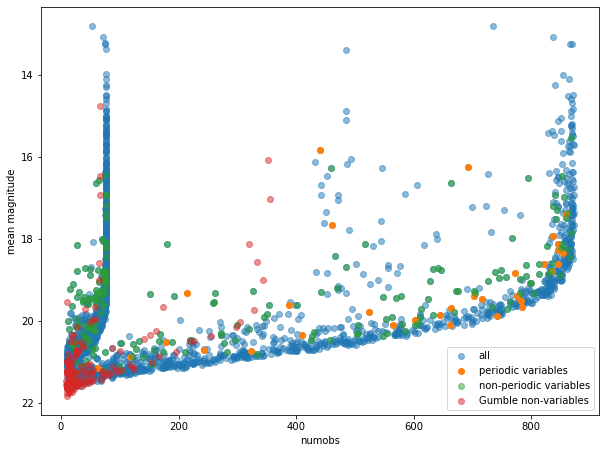

In [18]:
plt.figure(figsize=(10,7.5))
plt.scatter(t_zr['numobs'],t_zr['mean'],label='all',alpha=0.5)
plt.scatter(obj_zr['numobs'],obj_zr['mean'],label='periodic variables')
plt.scatter(unobj_zr['numobs'],unobj_zr['mean'],label='non-periodic variables',alpha=0.5)
plt.scatter(tt[tt['shape']=='gu']['numobs'],tt[tt['shape']=='gu']['mean'],label='Gumble non-variables',alpha=0.5)
plt.gca().invert_yaxis()
#plt.xscale('log')
plt.xlabel('numobs')
plt.ylabel('mean magnitude')
plt.legend()

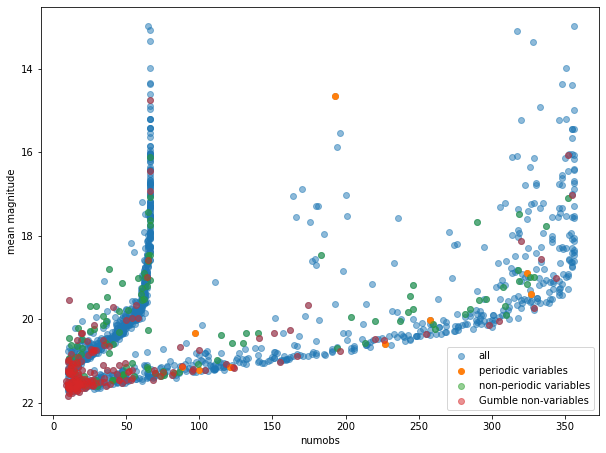

In [17]:
plt.figure(figsize=(10,7.5))
plt.scatter(t_zg['numobs'],t_zg['mean'],label='all',alpha=0.5)
plt.scatter(obj_zg['numobs'],obj_zg['mean'],label='periodic variables')
plt.scatter(unobj_zg['numobs'],unobj_zg['mean'],label='non-periodic variables',alpha=0.5)
plt.scatter(tt[tt['shape']=='gu']['numobs'],tt[tt['shape']=='gu']['mean'],label='Gumble non-variables',alpha=0.5)
plt.gca().invert_yaxis()
plt.xlabel('numobs')
plt.ylabel('mean magnitude')
plt.legend()

In [9]:
t=sourcefy(t_zr)

In [10]:
tt=t[np.isin(t['SourceID'],var_zr['SourceID'])==0]

In [11]:
len(tt[tt['shape']=='g1']),len(tt[tt['shape']=='gu']),len(tt[tt['shape']=='g2'])

(973, 303, 52)

In [12]:
tt[tt['shape']=='gu'].show_in_notebook()

idx,SourceID,filter,OID,RA,DEC,numobs,DELTA_SIG_MAG,CONST_CHI2,sf,rmse,LNP_SIG,period,period_c,power,power_c,mean,std,min,max,sigma_mean,sigma_std,gaussian1_err,gaussian2_err,gumbel_err,g2_flag,Pg1g2,Pgug2,Pg1gu,shape,upsilon_class,upsilon_prob,upsilon_flag,upsilon_period,identifier,dist,type,Gaia_count,Gmag,RFG,Plx,e_Plx,var
0,5,zr,806203100060430,5.070934,59.3008965,28,12.466414451599121,1.7283129662665804,0.5984174537666562,0.2532823085784912,0.007383182874099891,15.3971910489885,0.9973007154115933,0.8218173618839969,0.021587937890698784,21.132631301879883,0.2532823085784912,20.679914474487305,21.714054107666016,-0.12073443830013275,1.2867895364761353,1.0741960798709544,1.512499289139295,1.0584646325050022,0.0,0.8093635839006066,0.8251825806457277,0.4924867588857087,gu,EB_EC,0.4,1.0,0.17829168594744613,[HL90] 46a,1.241266,HII,0,0.0,0.0,0.0,0.0,N
1,6,zr,1809211300054379,5.0726338,59.3069596,52,18.35002326965332,1.4450468249753234,0.9317788481283706,0.16031809151172638,0.11513038102516225,0.11175381866929726,2800.0,0.2923195583973794,0.18403760183548382,20.32417869567871,0.16031809151172638,19.99271011352539,20.660245895385742,-0.12674126029014587,1.2099800109863281,0.4494014759041526,0.29656202015602845,0.4105430918565632,0.0,0.23028564819848318,0.2713924821681042,0.4540510642599983,gu,NonVar,0.44,1.0,0.03426764689794183,LGGS J002017.47+591825.1,0.15513,Em*,1,20.539137,131.705,1.1997,0.8904,N
2,2182,zr,806203100060428,5.0686987,59.3011576,31,14.597167015075684,2.5397979782940494,0.2010753927371321,0.278987854719162,0.004584205623594662,0.10915975604009884,0.9973200660635049,0.7675875229584677,0.02723589702929523,20.994417190551758,0.278987854719162,20.427616119384766,21.401565551757812,-0.1730046421289444,1.578710675239563,0.5175123958347051,0.6818459056520629,0.5103698750683476,0.0,0.7384251254826766,0.7531561671134391,0.49292232254581103,gu,DSCT,0.67,1.0,0.11233686461738165,--,nan,--,0,0.0,0.0,0.0,0.0,N
3,7,zr,1809211300070194,5.0765935,59.306523,21,13.404376029968262,1.3611729042566822,0.8496240945440536,0.18643465638160706,0.0009712057656648184,0.12183289580440618,2800.0,0.7633871860579919,0.062085698019975065,20.98085594177246,0.18643465638160706,20.425403594970703,21.25068473815918,-0.08848365396261215,1.1506891250610352,0.3937275934417054,0.6454053538236814,0.38979045282930785,1.0,0.9616937340230319,0.9697748007101733,0.4948817335706934,gu,DSCT,0.61,1.0,0.12183112796634757,[TG2009] 31,0.172675,Cl*,0,0.0,0.0,0.0,0.0,N
4,2185,zr,1809211300070228,5.065886,59.301641,13,22.00847625732422,5.40719163723965,0.0011817147564680722,0.29455700516700745,0.0016857112657659276,0.1665215023216044,2800.0,0.9122299125285599,0.5916235496963574,20.59902000427246,0.29455700516700745,19.993467330932617,20.970624923706055,-0.36190059781074524,2.3408825397491455,1.0471704516804254,1.7519487029641811,1.0433065283039131,1.0,0.977548704151579,0.9801612465276316,0.49811729626047196,gu,CEPH_F,0.26,1.0,5.916558080454507,--,nan,--,0,0.0,0.0,0.0,0.0,N
5,26,zr,1809211300074723,5.0675659,59.3085767,12,16.283884048461914,3.178348559622742,0.09443322056527081,0.23713882267475128,0.00020154927485384016,0.28589588748536904,2800.0,0.9614974356932032,0.10940622401794149,20.61071014404297,0.23713882267475128,20.15494155883789,20.88682746887207,-0.2190227508544922,1.7554858922958374,2.3872097900673097,2.994471121793778,2.373971917641834,0.0,0.6872328363147435,0.6929460545430732,0.49716795113241086,gu,RRL_c,0.26,1.0,0.2223508559199571,--,nan,--,0,0.0,0.0,0.0,0.0,N
6,28,zr,806203100052137,5.0819464,59.3019949,363,21.625120162963867,1.5267240399520312,0.9956156411295941,0.1794331669807434,0.010772064922677446,9.499891710318797,0.9973357126290449,0.10845194691105917,0.0026439448540464885,20.506973266601562,0.1794331669807434,20.03436279296875,21.120155334472656,-0.11694032698869705,1.2499923706054688,0.059058174409200075,0.02853148405710883,0.05102849355436138,0.0,0.12897599048795572,0.16960878834495963,0.42603290397437066,gu,NonVar,0.62,1.0,0.047885375002906995,

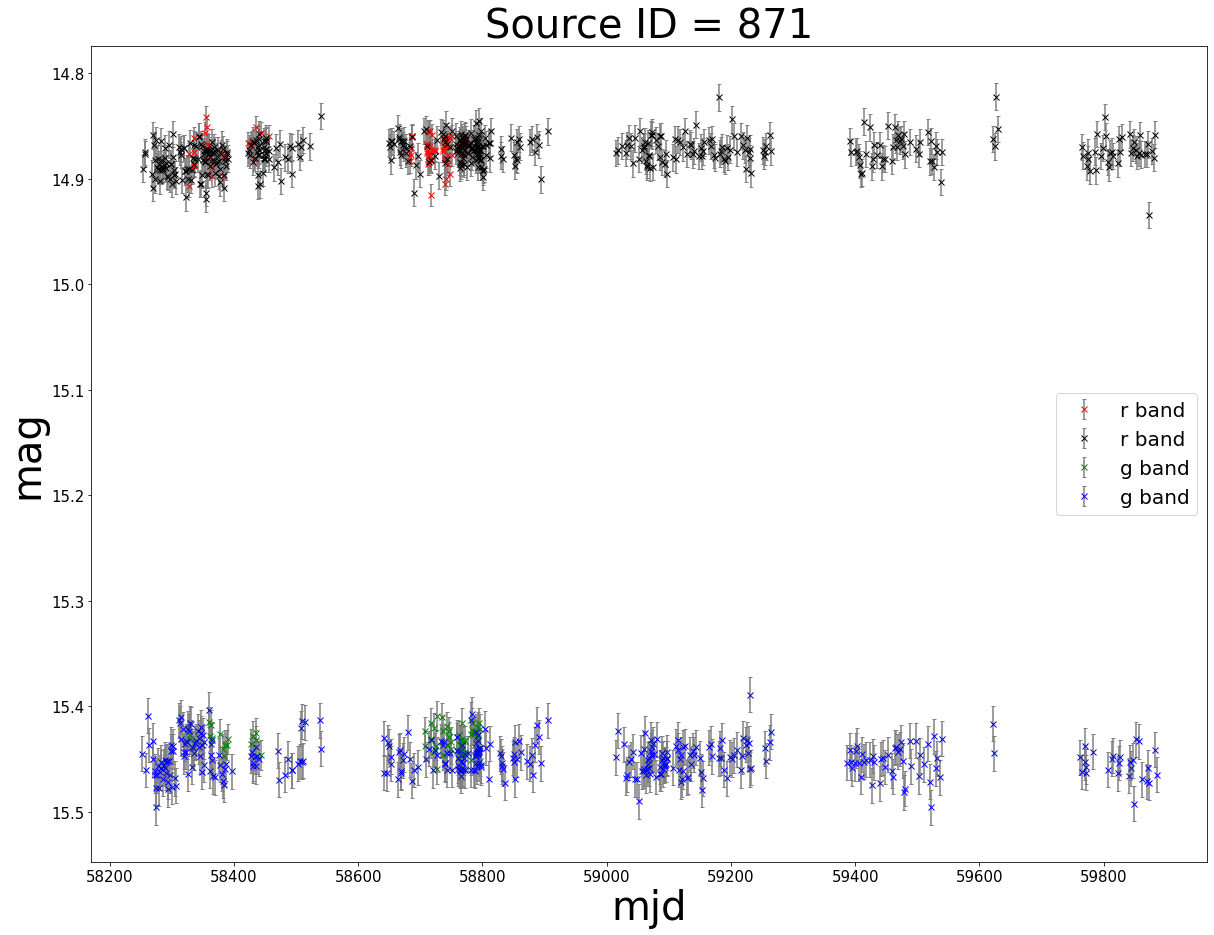

In [107]:
functions.draw_lightcurve(871)

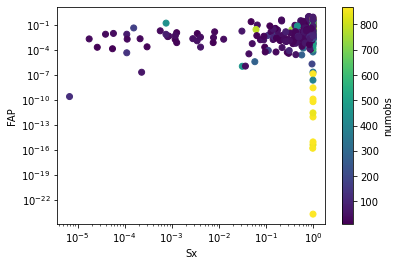

In [97]:
plt.scatter(tt[tt['shape']=='gu']['sf'],tt[tt['shape']=='gu']['LNP_SIG'],c=tt[tt['shape']=='gu']['numobs'])
plt.xlabel('Sx')
plt.ylabel('FAP')
plt.xscale('log')
plt.yscale('log')
plt.colorbar(label='numobs')

In [100]:
tt[tt['shape']=='g2'].show_in_notebook()

idx,SourceID,filter,OID,RA,DEC,numobs,DELTA_SIG_MAG,CONST_CHI2,sf,rmse,LNP_SIG,period,period_c,power,power_c,mean,std,min,max,sigma_mean,sigma_std,gaussian1_err,gaussian2_err,gumbel_err,g2_flag,Pg1g2,Pgug2,Pg1gu,shape,upsilon_class,upsilon_prob,upsilon_flag,upsilon_period,identifier,dist,type,Gaia_count,Gmag,RFG,Plx,e_Plx,var
0,11,zr,806203100057021,5.07886,59.302177,439,31.42368507385254,2.655923453433939,0.0003930970709695078,0.18843547999858856,0.018264385473507488,0.15722277501169674,0.997343815080248,0.08920894150375752,0.0003417610250562881,20.186723709106445,0.18843547999858856,19.61456871032715,20.60763931274414,-0.1945296823978424,1.6639478206634521,0.07318887527227534,0.020245111009047564,0.0867952901900692,0.0,0.044299846120880226,0.03179086416792265,0.5861092207622538,g2,NonVar,0.63,1.0,0.036365950318931896,LGGS J002018.90+591808.8,0.628504,Em*,0,0.0,0.0,0.0,0.0,N
1,2187,zr,806203100066409,5.0790746,59.3013948,234,25.81559944152832,1.4300533817097771,0.9942776372554428,0.1514436900615692,0.00902669246239602,1.1933490085233887,0.997336033066433,0.16634318457323463,0.00686921334414573,20.224821090698242,0.1514436900615692,19.784202575683594,20.710193634033203,-0.113322414457798,1.2073454856872559,0.11789066970665336,0.04204130433473794,0.2793855391425634,0.0,0.0723514343821875,0.013459402137854126,0.8611993089518942,g2,DSCT,0.8,1.0,0.08137398684404108,[HL90] 55,1.035203,HII,1,20.872219,62.3954,nan,nan,N
2,107,zr,806203100065432,5.0537228,59.2994666,354,22.948423385620117,2.8663962274228902,5.649783470328897e-05,0.27633973956108093,1.9831985249099693e-22,475.6919759026841,0.9973157097647236,0.4455083958492991,0.1868320014773206,20.701658248901367,0.27633973956108093,20.04710578918457,21.38593292236328,-0.2179374098777771,1.7309147119522095,0.020898771877050838,0.005355123131041611,0.023781615071955843,0.0,0.038180332590132426,0.029678840488872482,0.5654934345597256,g2,LPV_SRV_AGB_C,0.42,0.0,446.97659027999987,--,nan,--,1,19.860453,154.847,-0.6696,0.4064,N
3,186,zr,806203100063299,5.1006125,59.301887,576,40.48589324951172,2.080000786738457,0.30111655925493874,0.15707474946975708,0.00017257951727251658,0.9989174954228719,0.997336033066433,0.1014306799334545,0.17820769229957445,20.073694229125977,0.15707474946975708,19.402433395385742,20.6334228515625,-0.1470080465078354,1.463769793510437,0.006139041584829247,0.0013855259560222517,0.07070589302781127,0.0,0.029810706649246455,0.00023421559842362605,0.9977125751182438,g2,DSCT,0.82,1.0,0.09117910649713551,--,nan,--,1,19.941666,240.792,0.2066,0.416,N
4,205,zr,806203100043620,5.1005157,59.3083367,671,37.691593170166016,2.4536063664823606,0.0015779403124817136,0.16508138179779053,4.7928908994661535e-25,2043.207284960579,0.997336033066433,0.2889360399973322,0.4587781818881762,19.94676971435547,0.16508138179779053,19.44925308227539,20.417360305786133,-0.17698395252227783,1.5938605070114136,0.07225736691644444,0.02405567354203479,0.08362722105200802,0.0,0.06338772140649773,0.04779253925915905,0.573965096785739,g2,NonVar,0.45,0.0,4535.704652700006,--,nan,--,1,19.498354,222.849,-0.0661,0.2733,N
5,243,zr,806203100065957,5.0537389,59.2903854,570,24.02338218688965,1.243890879086938,0.9999999762545343,0.1379941701889038,0.0001471414750098902,1.0351985220482898,0.997338895506679,0.10303828457534785,0.022947682326560304,20.206974029541016,0.1379941701889038,19.805191040039062,20.624862670898438,-0.09856399893760681,1.1266624927520752,0.020961868728024333,0.00198127716161949,0.02387216873700272,0.0,0.005370109896054465,0.004150001012027671,0.565887837971153,g2,EB_ESD,0.51,1.0,1.03519739763615,--,nan,--,1,19.991388,278.189,0.4642,0.3932,N
6,250,zr,806203100064642,5.0395718,59.3040074,89,21.46367073059082,3.137718114550939,0.007134716403827935,0.2771444618701935,0.009739571731345932,0.11158376405921021,0.9972108858153861,0.3748534938218083,0.0494731104337189,20.91674041748047,0.2771444618701935,20.141990661621094,21.528152465820312,-0.20328064262866974,1.7957358360290527,0.08642856696262903

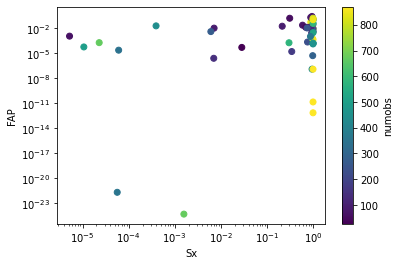

In [99]:
plt.scatter(tt[tt['shape']=='g2']['sf'],tt[tt['shape']=='g2']['LNP_SIG'],c=tt[tt['shape']=='g2']['numobs'])
plt.xlabel('Sx')
plt.ylabel('FAP')
plt.xscale('log')
plt.yscale('log')
plt.colorbar(label='numobs')

L-S_period: 2043.207284960579
fit_period: 1679.5616579648931
sin_chi2: 1.8187674
L-S_period: 0.33193561586844966
fit_period: 0.46327581032742654
sin_chi2: 1.41143267


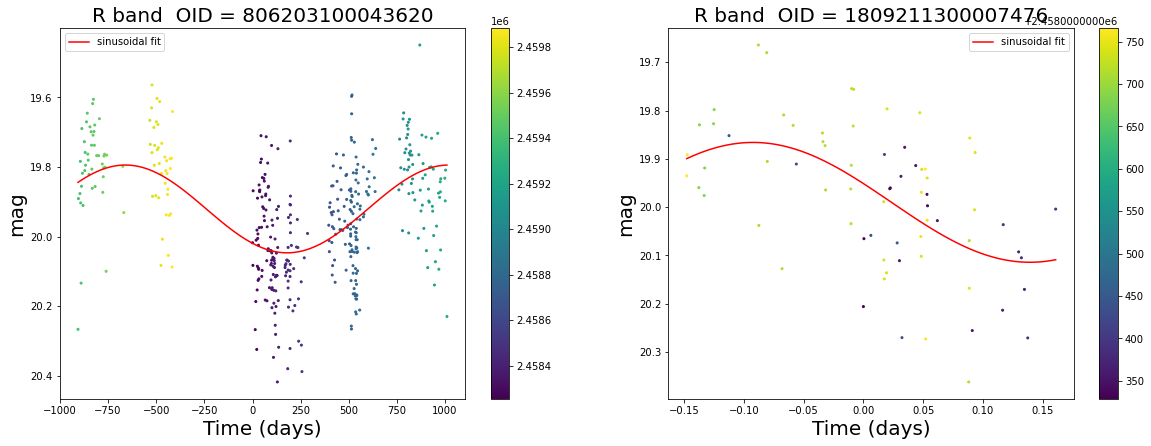

In [108]:
functions.sinfit(205)

No data found in G band


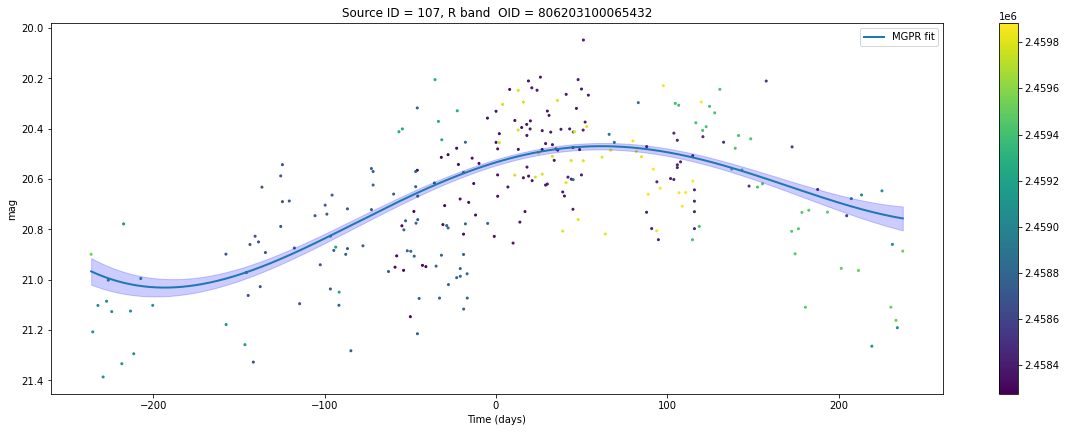

In [110]:
functions.MGPRfit(107)

In [49]:
tt=t[np.isin(t['SourceID'],obj_zr['SourceID'])==1]
len(tt[tt['shape']=='g1']),len(tt[tt['shape']=='gu']),len(tt[tt['shape']=='g2'])

(14, 4, 14)

In [50]:
tt=t[np.isin(t['SourceID'],unobj_zr['SourceID'])==1]
len(tt[tt['shape']=='g1']),len(tt[tt['shape']=='gu']),len(tt[tt['shape']=='g2'])

(105, 25, 26)

In [16]:
t=sourcefy(t_zg)
tt=t[np.isin(t['SourceID'],var_zg['SourceID'])==0]
len(tt[tt['shape']=='g1']),len(tt[tt['shape']=='gu']),len(tt[tt['shape']=='g2'])

(542, 176, 45)

In [30]:
t=sourcefy(t_zg)
tt=t[np.isin(t['SourceID'],var_zg['SourceID'])==0]
tt[tt['shape']=='gu']

SourceID,filter,OID,RA,DEC,numobs,DELTA_SIG_MAG,CONST_CHI2,sf,rmse,LNP_SIG,period,period_c,power,power_c,mean,std,min,max,sigma_mean,sigma_std,gaussian1_err,gaussian2_err,gumbel_err,g2_flag,Pg1g2,Pgug2,Pg1gu,shape,upsilon_class,upsilon_prob,upsilon_flag,upsilon_period,identifier,dist,type,Gaia_count,Gmag,RFG,Plx,e_Plx,var
int32,str2,str16,float64,float64,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str2,str14,float64,float64,float64,str37,float64,str15,int32,float64,float64,float64,float64,str1
15,zg,806103100036255,5.0668564,59.3003302,28,14.36984920501709,1.6229965422976425,0.7468259825551729,0.21113960444927216,0.007936575452639556,0.11386585524801675,0.4993080926058333,0.5638251835783713,0.17635647253309827,21.276466369628906,0.21113960444927216,20.755855560302734,21.65484046936035,-0.09037730097770691,1.2624156475067139,0.3891580093308588,0.6084127596908213,0.38566186716716727,1.0,0.9185276831520723,0.9272558921464341,0.4954039889095636,gu,DSCT,0.74,1.0,0.07209751431055461,[HL90] 44,1.676995,HII,1,21.065866,42.6338,nan,nan,N
22,zg,806103100036246,5.0802724,59.301157,13,22.23741912841797,4.504351702870187,0.00766059034512491,0.31902575492858887,0.0038661655790040374,0.16825365505050724,0.9974583718434213,0.8903187594850689,0.47644858430397485,21.07503890991211,0.31902575492858887,20.38677406311035,21.609285354614258,-0.24394336342811584,2.086744546890259,0.6288150968575865,0.44002241448709806,0.6146050198231612,0.0,0.25623078608988736,0.26705231782760874,0.4883605788771028,gu,DSCT,0.56,1.0,0.032243810698215566,[GTA2012] 27,1.523743,PN?_Candidate,0,0.0,0.0,0.0,0.0,N
33,zg,806103100040240,5.083407,59.30432,220,30.433420181274414,1.6660500936965488,0.967121364974451,0.16184024512767792,3.5721254786864088e-06,29.583740030286975,1.0000175167475613,0.16808121206378762,0.0752978840474468,20.485431671142578,0.16184024512767792,19.914899826049805,20.934471130371094,-0.1072433814406395,1.302003264427185,0.056059171394649464,0.02922306361383855,0.05068778579976715,1.0,0.14879997808647494,0.1795534315110694,0.4488536492951124,gu,EB_ESD,0.23,1.0,29.624256898026275,--,nan,--,1,19.254812,369.66,0.4323,0.2444,N
36,zg,806103100040253,5.0820202,59.3008032,54,25.511367797851562,2.2136227329558986,0.27570157457773425,0.22602035105228424,0.000396554853338229,0.9973038024878157,1.0000453277723564,0.43097544472151533,0.9594746343460272,21.211116790771484,0.22602035105228424,20.289213180541992,21.717479705810547,-0.11680058389902115,1.4910389184951782,0.055286467862580006,0.09344713482245887,0.017926260083711294,0.0,0.9845453377386271,1.0,0.08021385746058696,gu,DSCT,0.52,1.0,0.09579691332128562,--,nan,--,1,20.858891,89.9628,0.7563,1.539,N
44,zg,806103100036198,5.0598002,59.3064705,104,25.032480239868164,2.584345396778671,0.024074212440324923,0.260050505399704,0.004078732055766926,0.26719690010290514,1.0000423459019012,0.217712815840652,0.025266168728020462,21.208574295043945,0.260050505399704,20.316295623779297,21.748809814453125,-0.14629590511322021,1.622204303741455,0.027780543451929363,0.01523850834432191,0.01726330736098222,0.0,0.16366750586519108,0.3871361766895116,0.27271169947902096,gu,RRL_c,0.44,1.0,0.3323871195820365,--,nan,--,1,21.0396,54.6742,nan,nan,N
68,zg,806103100036160,5.0642367,59.3111206,88,17.329315185546875,1.3644329985805257,0.9901753573203305,0.18720780313014984,0.05748443944181227,0.13548347626495608,0.9973380725525357,0.1982726976861085,0.04896192269372303,21.127485275268555,0.18720780313014984,20.55790901184082,21.530765533447266,-0.07817540317773819,1.1700018644332886,0.17972898057412748,0.281058555925502,0.15198150310156885,1.0,0.9187669603511048,1.0,0.4152904019526713,gu,DSCT,0.88,1.0,0.06241112955915335,--,nan,--,0,0.0,0.0,0.0,0.0,N
78,zg,806103100040285,5.0690993,59.2953914,17,8.756695747375488,0.7876638458771819,0.9871635597702737,0.15188758075237274,0.008776547990006914,0.24659147

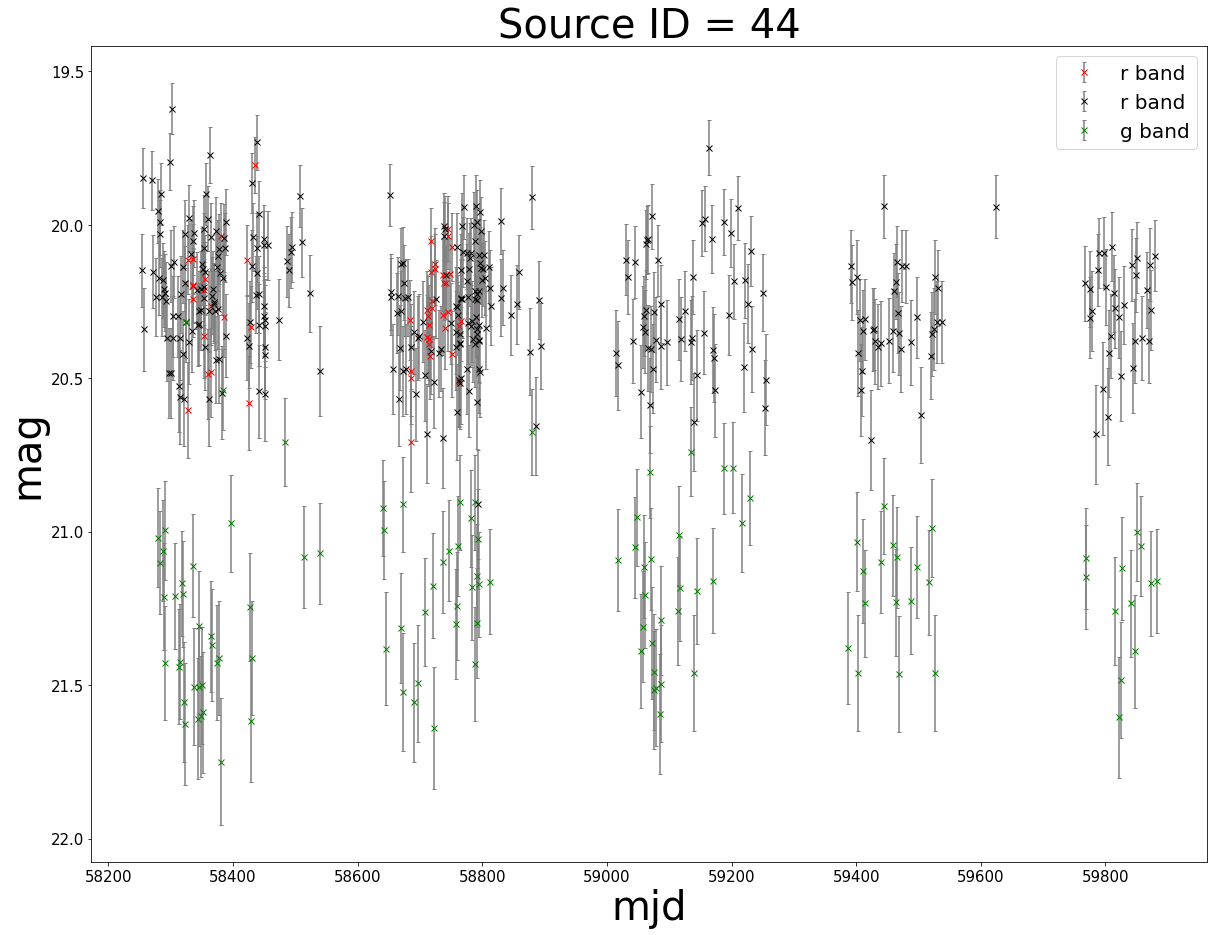

In [54]:
functions.draw_lightcurve(44)

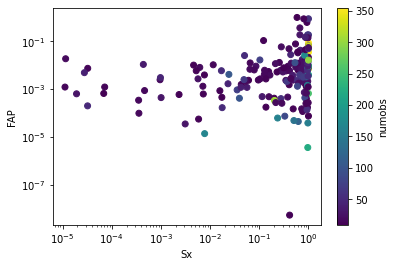

In [91]:
plt.scatter(tt[tt['shape']=='gu']['sf'],tt[tt['shape']=='gu']['LNP_SIG'],c=tt[tt['shape']=='gu']['numobs'])
plt.xlabel('Sx')
plt.ylabel('FAP')
plt.xscale('log')
plt.yscale('log')
plt.colorbar(label='numobs')

In [53]:
tt[tt['shape']=='g2']

SourceID,filter,OID,RA,DEC,numobs,DELTA_SIG_MAG,CONST_CHI2,sf,rmse,LNP_SIG,period,period_c,power,power_c,mean,std,min,max,sigma_mean,sigma_std,gaussian1_err,gaussian2_err,gumbel_err,g2_flag,Pg1g2,Pgug2,Pg1gu,shape,upsilon_class,upsilon_prob,upsilon_flag,upsilon_period,identifier,dist,type,Gaia_count,Gmag,RFG,Plx,e_Plx,var
int32,str2,str16,float64,float64,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str2,str14,float64,float64,float64,str37,float64,str15,int32,float64,float64,float64,float64,str1
28,zg,806103100048930,5.082168,59.3019222,33,19.616378784179688,2.5738338905879066,0.12820984112543513,0.2758341133594513,0.0011741215064084804,0.15824089494401172,0.9973982279255794,0.5734457445365949,0.03239384925644873,21.380706787109375,0.2758341133594513,20.615158081054688,21.93632698059082,-0.14389534294605255,1.6011770963668823,0.129415266876725,0.03103102237841219,0.09270442385652497,0.0,0.03354888199169903,0.06405483361644126,0.33543739941026973,g2,DSCT,0.72,1.0,0.10860264286792665,--,nan,--,1,20.776953,87.8545,0.7554,1.5842,N
48,zg,806103100048061,5.0696753,59.310551,42,31.379552841186523,3.826511080841693,0.0003868333594730508,0.22189907729625702,0.005537442085912361,0.678597517237246,0.9972241788336761,0.4422139304698259,0.0005953931696507162,20.563793182373047,0.22189907729625702,19.89342498779297,20.942089080810547,-0.21152903139591217,1.9759795665740967,0.06763487052442466,0.024500896181123527,0.09258578036217797,0.0,0.07456407231942797,0.04064822225103937,0.6554528578979111,g2,RRL_d,0.32,1.0,0.4038386130382646,--,nan,--,0,0.0,0.0,0.0,0.0,N
97,zg,806103100045137,5.0787962,59.3131099,212,50.576107025146484,2.450304328420767,0.013526566438279194,0.1456177830696106,0.000733361207598517,0.10079381595462017,1.0000143393856216,0.12993941787723934,0.016720746901803633,20.116304397583008,0.1456177830696106,19.400123596191406,20.445493698120117,-0.13428141176700592,1.581860899925232,0.040492436248361,0.007249898317625742,0.12277128100173759,0.0,0.018943700075168768,0.002110819564001609,0.9167180223998062,g2,NonVar,0.54,1.0,0.05334954482134036,--,nan,--,1,19.24836,435.111,0.7107,0.2409,N
98,zg,806103100049149,5.0810306,59.2949935,80,34.341732025146484,3.0050212514837673,0.002095460067084848,0.22381256520748138,0.0016564999456871452,1.6346671380571522,0.99734750870836,0.27717301707842273,0.0018854369520744153,21.00124168395996,0.22381256520748138,19.93695640563965,21.565547943115234,-0.14606332778930664,1.749303936958313,0.05876233928611598,0.006635172902308558,0.12197868894995305,0.0,0.007636077654319728,0.0017927165611598683,0.8219153354789737,g2,NonVar,0.47,1.0,0.07336868019797067,--,nan,--,0,0.0,0.0,0.0,0.0,N
113,zg,806103100036178,5.0541003,59.3094205,34,25.333425521850586,4.625086367985471,2.15900488760617e-05,0.3092106282711029,4.5987263580415014e-05,388.44922068490047,0.9973190112204673,0.6395431622694664,0.586270321277334,21.360750198364258,0.3092106282711029,20.305557250976562,21.754261016845703,-0.22151397168636322,2.167623996734619,0.013765164936468144,0.005573481732928318,0.019356750398774065,0.0,0.09226033710221737,0.04788310599249346,0.6679251845039422,g2,DSCT,0.45,1.0,0.07010285598319828,--,nan,--,0,0.0,0.0,0.0,0.0,N
117,zg,806103100019924,5.0518132,59.3072754,333,269.6783142089844,1.5677574546623918,0.9986998153741847,0.019728444516658783,0.0007331132953189067,96.05863924337996,1.0000143393856216,0.08704681287416759,0.02573131843971095,14.91539478302002,0.019728444516658783,14.848270416259766,14.982725143432617,-0.0017379275523126125,1.250251054763794,0.6127291038815077,0.18162044553384477,4.74241575221756,0.0,0.05065129415430503,0.0008913792922204955,0.9925172288212869,g2,LPV_OSARG_RGB,0.47,1.0,96.5081914851064,--,nan,--,1,14.064096,6565.42,2.8276,0.0154,N
244,zg,806103100042736,5.1002162,59.2958342,87,22.45268440246582,2.223734342874763,0.22187498847710305,0.23678474128246307,0.0

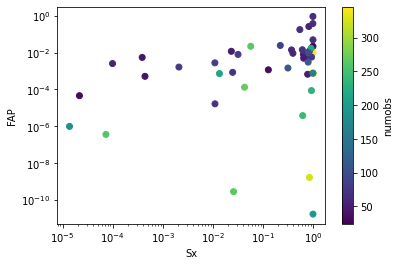

In [92]:
plt.scatter(tt[tt['shape']=='g2']['sf'],tt[tt['shape']=='g2']['LNP_SIG'],c=tt[tt['shape']=='g2']['numobs'])
plt.xlabel('Sx')
plt.ylabel('FAP')
plt.xscale('log')
plt.yscale('log')
plt.colorbar(label='numobs')

In [76]:
functions.query(97)

SourceID,filter,OID,RA,DEC,numobs,DELTA_SIG_MAG,CONST_CHI2,sf,rmse,LNP_SIG,period,period_c,power,power_c,mean,std,min,max,sigma_mean,sigma_std,gaussian1_err,gaussian2_err,gumbel_err,g2_flag,Pg1g2,Pgug2,Pg1gu,shape,upsilon_class,upsilon_prob,upsilon_flag,upsilon_period
int32,str2,str16,float64,float64,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str2,str14,float64,float64,float64
97,zr,1809211300073377,5.0788614,59.3130081,72,109.92912292480469,3.689002940165655,1.9448076091178725e-05,0.08722908049821854,9.070506399867446e-06,326.09708073769036,2800.0,0.4189196506483699,0.9521389837627448,18.967880249023438,0.08722908049821854,18.63969612121582,19.15943145751953,-0.11257585883140564,1.9182560443878174,0.8246368758442368,0.22564564503636045,0.9466641219011105,1.0,0.04337689289808899,0.03316263996831914,0.5698951730482915,g1,NonVar,0.49,1.0,0.1072391797820822
97,zr,806203100064616,5.0787821,59.3130516,780,146.99476623535156,4.089150335216777,2.0151904774264857e-32,0.09559094160795212,0.0016400882110632132,0.9972039763027732,0.9973357126290449,0.06740723788392138,0.9007378723897052,18.966588973999023,0.09559094160795212,18.433612823486328,19.197866439819336,-0.12420780956745148,2.0329267978668213,0.03208728486535358,0.00948482812445164,0.2608990308598504,1.0,0.050381140415505565,0.0008035436655599026,0.9935133884999126,g1,NonVar,0.48,1.0,0.1830484542309863


SourceID,filter,OID,RA,DEC,numobs,DELTA_SIG_MAG,CONST_CHI2,sf,rmse,LNP_SIG,period,period_c,power,power_c,mean,std,min,max,sigma_mean,sigma_std,gaussian1_err,gaussian2_err,gumbel_err,g2_flag,Pg1g2,Pgug2,Pg1gu,shape,upsilon_class,upsilon_prob,upsilon_flag,upsilon_period
int32,str2,str16,float64,float64,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str2,str14,float64,float64,float64
97,zg,1809111300052422,5.0788536,59.3130308,36,22.048561096191406,1.254396388466095,0.9580293360933534,0.12421110272407532,0.0007890410213054692,0.49087003747955427,2800.0,0.555627262290149,0.06530077193082548,20.091346740722656,0.12421110272407532,19.74752426147461,20.33478546142578,-0.08854076266288757,1.1153197288513184,1.2863508072825491,1.5114718604683817,1.190558413509381,0.0,0.6219790566383869,0.6996097030502695,0.4606558868609215,gu,RRL_ab,0.32,1.0,0.490885134297077
97,zg,806103100045137,5.0787962,59.3131099,212,50.576107025146484,2.450304328420767,0.013526566438279194,0.1456177830696106,0.000733361207598517,0.10079381595462017,1.0000143393856216,0.12993941787723934,0.016720746901803633,20.116304397583008,0.1456177830696106,19.400123596191406,20.445493698120117,-0.13428141176700592,1.581860899925232,0.040492436248361,0.007249898317625742,0.12277128100173759,0.0,0.018943700075168768,0.002110819564001609,0.9167180223998062,g2,NonVar,0.54,1.0,0.05334954482134036


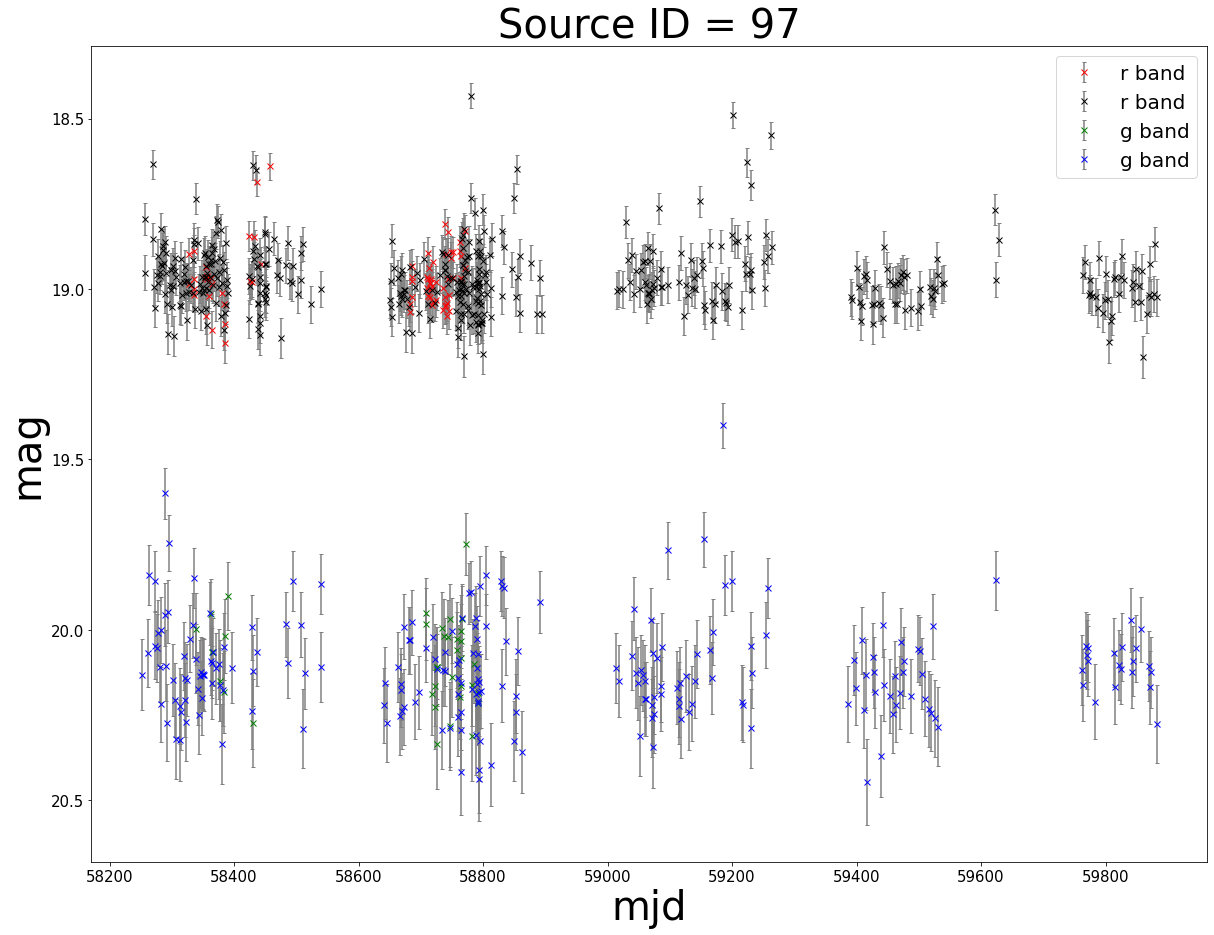

In [55]:
functions.draw_lightcurve(97)

In [58]:
tt=t[np.isin(t['SourceID'],obj_zg['SourceID'])==1]
len(tt[tt['shape']=='g1']),len(tt[tt['shape']=='gu']),len(tt[tt['shape']=='g2'])

(8, 0, 1)

In [59]:
tt=t[np.isin(t['SourceID'],unobj_zg['SourceID'])==1]
len(tt[tt['shape']=='g1']),len(tt[tt['shape']=='gu']),len(tt[tt['shape']=='g2'])

(53, 24, 15)

In [60]:
t_color=QTable.read('t_color_0912.ecsv')

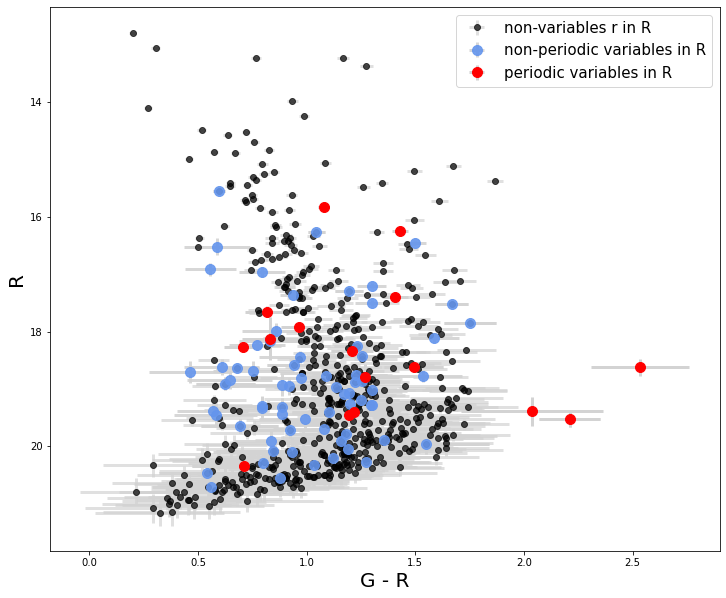

In [70]:
plt.figure(figsize=(12,10))
plt.gca().invert_yaxis()
plt.xlabel('G - R',fontsize=20)
plt.ylabel('R',fontsize=20)

# nonvar_zr
t_plot=t_color[np.isin(t_color['SourceID'],np.unique(nonvar_zr['SourceID']))]
t_plot=t_plot[np.isnan(t_plot['mean_color'])==False]

plt.errorbar(t_plot['mean_color'],t_plot['mean_mag_r'],xerr=t_plot['std_color'],yerr=t_plot['std_mag_r'],fmt='o',color='black',
             ecolor='lightgray', elinewidth=3, capsize=0,alpha=0.7,label='non-variables r in R')


# unobj_zr
t_plot=t_color[np.isin(t_color['SourceID'],np.unique(unobj_zr['SourceID']))]
t_plot=t_plot[np.isnan(t_plot['mean_color'])==False]

plt.errorbar(t_plot['mean_color'],t_plot['mean_mag_r'],xerr=t_plot['std_color'],yerr=t_plot['std_mag_r'],fmt='o',color='cornflowerblue',markersize=10,
             ecolor='lightgray', elinewidth=3, capsize=0,alpha=0.9,label='non-periodic variables in R')


# obj_zr
t_plot=t_color[np.isin(t_color['SourceID'],np.unique(obj_zr['SourceID']))]
t_plot=t_plot[np.isnan(t_plot['mean_color'])==False]

plt.errorbar(t_plot['mean_color'],t_plot['mean_mag_r'],xerr=t_plot['std_color'],yerr=t_plot['std_mag_r'],fmt='o',color='red',markersize=10,
             ecolor='lightgray', elinewidth=3, capsize=0,alpha=1,label='periodic variables in R')

#plt.xlim(0,2)
#plt.ylim(21,18)
plt.legend(loc=0,fontsize=15)

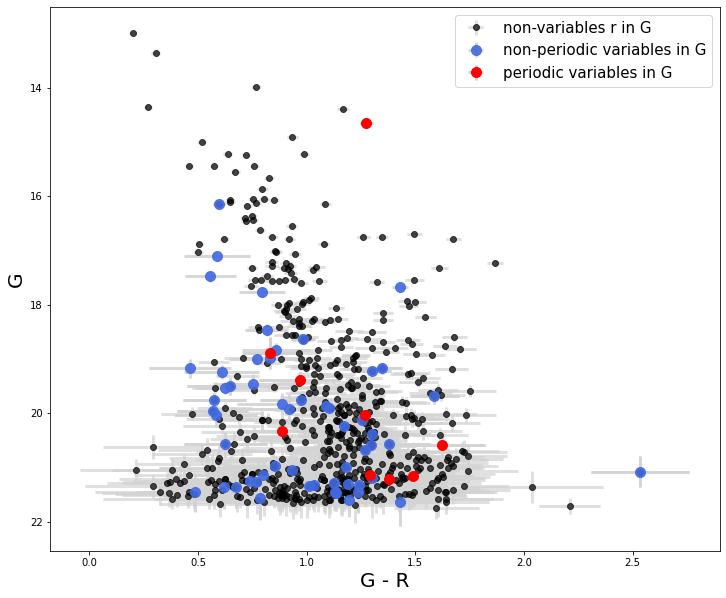

In [74]:
plt.figure(figsize=(12,10))
plt.gca().invert_yaxis()
plt.xlabel('G - R',fontsize=20)
plt.ylabel('G',fontsize=20)

# nonvar_zg
t_plot=t_color[np.isin(t_color['SourceID'],np.unique(nonvar_zg['SourceID']))]
t_plot=t_plot[np.isnan(t_plot['mean_color'])==False]

plt.errorbar(t_plot['mean_color'],t_plot['mean_mag_g'],xerr=t_plot['std_color'],yerr=t_plot['std_mag_g'],fmt='o',color='black',
             ecolor='lightgray', elinewidth=3, capsize=0,alpha=0.7,label='non-variables r in G')


# unobj_zg
t_plot=t_color[np.isin(t_color['SourceID'],np.unique(unobj_zg['SourceID']))]
t_plot=t_plot[np.isnan(t_plot['mean_color'])==False]

plt.errorbar(t_plot['mean_color'],t_plot['mean_mag_g'],xerr=t_plot['std_color'],yerr=t_plot['std_mag_g'],fmt='o',color='royalblue',markersize=10,
             ecolor='lightgray', elinewidth=3, capsize=0,alpha=0.9,label='non-periodic variables in G')


# obj_zg
t_plot=t_color[np.isin(t_color['SourceID'],np.unique(obj_zg['SourceID']))]
t_plot=t_plot[np.isnan(t_plot['mean_color'])==False]

plt.errorbar(t_plot['mean_color'],t_plot['mean_mag_g'],xerr=t_plot['std_color'],yerr=t_plot['std_mag_g'],fmt='o',color='red',markersize=10,
             ecolor='lightgray', elinewidth=3, capsize=0,alpha=1,label='periodic variables in G')

#plt.xlim(0,2)
#plt.ylim(21,18)
plt.legend(loc=0,fontsize=15)

In [75]:
t_plot

SourceID,mean_color,std_color,max_color,min_color,mean_mag_r,std_mag_r,max_mag_r,min_mag_r,mean_mag_g,std_mag_g,max_mag_g,min_mag_g
int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
73,0.8864079475402832,0.1913117245438033,1.3744182586669922,0.04401969909667969,19.436952590942383,0.14209401607513428,19.732688903808594,18.890762329101562,20.327228546142578,0.23146717250347137,20.794662475585938,19.153165817260742
77,1.2697524060024303,0.1566320560352759,1.6706371307373047,0.6612396240234375,18.791976928710938,0.22717958688735962,19.1998348236084,17.675485610961914,20.02450942993164,0.31344184279441833,20.759401321411133,18.832887649536133
90,0.8292514394830774,0.12669687043914363,1.374359130859375,0.23621368408203125,18.124500274658203,0.3739984333515167,18.949966430664062,17.195171356201172,18.898109436035156,0.29480019211769104,19.611181259155273,18.297286987304688
443,1.4895788304946003,0.27677218723214253,2.009279251098633,0.4928855895996094,19.699129104614258,0.10129835456609726,20.088769912719727,19.336618423461914,21.151514053344727,0.26791107654571533,21.6740779876709,20.161453247070312
959,1.292448274020491,0.32174211991011553,1.7794685363769531,0.10829544067382812,19.83580207824707,0.12982550263404846,20.39980697631836,19.30921745300293,21.140100479125977,0.2844848036766052,21.54222869873047,19.84897232055664
1219,1.6213697791099548,0.2010975983195594,2.151805877685547,0.49092864990234375,18.98127555847168,0.0579012855887413,19.188018798828125,18.759069442749023,20.59395980834961,0.19112929701805115,21.078689575195312,19.435989379882812
1642,1.2746296130435568,0.028856604997819682,1.3418426513671875,1.1856212615966797,13.373697280883789,0.015153578482568264,13.433606147766113,13.315940856933594,14.649717330932617,0.03029390051960945,14.71679973602295,14.5626220703125
1742,1.378161883354187,0.3489591595306736,1.9429969787597656,-0.26885223388671875,19.831071853637695,0.10571683198213577,20.246143341064453,19.405582427978516,21.214624404907227,0.2907710373401642,21.729793548583984,19.77669334411621
2091,0.9674321183370888,0.18499700571083189,1.9125900268554688,0.05344581604003906,18.44174575805664,0.10200228542089462,19.071861267089844,18.096073150634766,19.395851135253906,0.16449441015720367,20.01334571838379,18.669248580932617


In [76]:
t_plot=t_color[np.isin(t_color['SourceID'],np.unique(nonvar_zr['SourceID']))]
t_plot=t_plot[np.isnan(t_plot['mean_color'])==False]
(t_plot['max_mag_r']-t_plot['min_mag_r']).mean(),t_plot['std_mag_r'].mean(),(t_plot['max_color']-t_plot['min_color']).mean(),t_plot['std_color'].mean()

(0.6671070418991409,
 0.09469715367605376,
 0.8590207233295574,
 0.1631466644142896)

In [77]:
t_plot=t_color[np.isin(t_color['SourceID'],np.unique(unobj_zr['SourceID']))]
t_plot=t_plot[np.isnan(t_plot['mean_color'])==False]
(t_plot['max_mag_r']-t_plot['min_mag_r']).mean(),t_plot['std_mag_r'].mean(),(t_plot['max_color']-t_plot['min_color']).mean(),t_plot['std_color'].mean()

(0.9979933991151697,
 0.13429566264590798,
 0.9860747701981488,
 0.17861465959361011)

In [78]:
t_plot=t_color[np.isin(t_color['SourceID'],np.unique(obj_zr['SourceID']))]
t_plot=t_plot[np.isnan(t_plot['mean_color'])==False]
(t_plot['max_mag_r']-t_plot['min_mag_r']).mean(),t_plot['std_mag_r'].mean(),(t_plot['max_color']-t_plot['min_color']).mean(),t_plot['std_color'].mean()

(0.7861508727073669,
 0.13616155344061553,
 0.839984118938446,
 0.1399782964074667)

In [79]:
t_plot=t_color[np.isin(t_color['SourceID'],np.unique(nonvar_zg['SourceID']))]
t_plot=t_plot[np.isnan(t_plot['mean_color'])==False]
(t_plot['max_mag_g']-t_plot['min_mag_g']).mean(),t_plot['std_mag_g'].mean(),(t_plot['max_color']-t_plot['min_color']).mean(),t_plot['std_color'].mean()

(0.8971893154844945,
 0.1560472096173967,
 0.8556933013760314,
 0.16063083000024062)

In [80]:
t_plot=t_color[np.isin(t_color['SourceID'],np.unique(unobj_zg['SourceID']))]
t_plot=t_plot[np.isnan(t_plot['mean_color'])==False]
(t_plot['max_mag_g']-t_plot['min_mag_g']).mean(),t_plot['std_mag_g'].mean(),(t_plot['max_color']-t_plot['min_color']).mean(),t_plot['std_color'].mean()

(1.33210242878307, 0.21771893616427074, 1.066195418617942, 0.2030616516296987)

In [81]:
t_plot=t_color[np.isin(t_color['SourceID'],np.unique(obj_zg['SourceID']))]
t_plot=t_plot[np.isnan(t_plot['mean_color'])==False]
(t_plot['max_mag_g']-t_plot['min_mag_g']).mean(),t_plot['std_mag_g'].mean(),(t_plot['max_color']-t_plot['min_color']).mean(),t_plot['std_color'].mean()

(1.4646512137518988,
 0.22986597029699218,
 1.394844479031033,
 0.20411836963548502)

In [82]:
t_zr=QTable.read('t_zr_1024.ecsv')
t_zg=QTable.read('t_zg_1024.ecsv')
t_zr=t_zr[np.isnan(t_zr['LNP_SIG'])==False]
t_zg=t_zg[np.isnan(t_zg['LNP_SIG'])==False]

In [83]:
upsilon_zr=t_zr[t_zr['upsilon_class']!='NonVar']
upsilon_zg=t_zg[t_zg['upsilon_class']!='NonVar']
upsilon_zr=upsilon_zr[upsilon_zr['upsilon_flag']==0]
upsilon_zg=upsilon_zg[upsilon_zg['upsilon_flag']==0]

In [84]:
len(np.unique(upsilon_zr['SourceID'])),len(np.unique(upsilon_zg['SourceID'])),len(np.unique(upsilon_zr[np.isin(upsilon_zr['SourceID'],upsilon_zg['SourceID'])==1]['SourceID']))

(35, 15, 4)

In [85]:
len(np.intersect1d(np.unique(obj_zr['SourceID']),np.unique(upsilon_zr['SourceID'])))

23

In [86]:
len(np.intersect1d(np.unique(obj_zg['SourceID']),np.unique(upsilon_zg['SourceID'])))

3

In [87]:
np.intersect1d(np.unique(obj_zr['SourceID']),np.unique(obj_zg['SourceID']))

array([77, 90])

In [88]:
np.intersect1d(np.unique(obj_zr['SourceID']),np.unique(upsilon_zr['SourceID']))

array([  52,   77,   90,  158,  168,  208,  210,  223,  225,  242,  265,
        354,  530,  577,  733,  778, 1169, 1259, 1299, 1555, 1706, 1744,
       2008])

In [89]:
upsilon_zr

SourceID,filter,OID,RA,DEC,numobs,DELTA_SIG_MAG,CONST_CHI2,sf,rmse,LNP_SIG,period,period_c,power,power_c,mean,std,min,max,sigma_mean,sigma_std,gaussian1_err,gaussian2_err,gumbel_err,g2_flag,Pg1g2,Pgug2,Pg1gu,shape,upsilon_class,upsilon_prob,upsilon_flag,upsilon_period
int32,str2,str16,float64,float64,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str2,str14,float64,float64,float64
50,zr,806203100056992,5.0847793,59.305823,438,26.07579231262207,2.6107927423368156,0.000806971208849762,0.23083563148975372,3.463105648531134e-12,223.91194916677907,0.997343815080248,0.24246865168903964,0.06281874602726414,20.486726760864258,0.23083563148975372,19.869138717651367,21.093555450439453,-0.20032791793346405,1.6513630151748657,0.020899946420963187,0.010016017577819572,0.02540505403358542,0.0,0.12703363363379405,0.08768528986628421,0.5983224576127097,g1,LPV_SRV_AGB_O,0.86,0.0,226.33803819000025
52,zr,806203100023276,5.0806496,59.3093092,664,48.39557647705078,9.548270702053268,1.3227187319910005e-189,0.3108588755130768,1.7018337280194596e-78,595.2450708466688,0.997336033066433,0.6229683753591274,0.21949631231274336,19.675853729248047,0.3108588755130768,19.17412567138672,20.918895721435547,-0.7161276936531067,3.285275936126709,0.05060821258505381,0.007833020026423389,0.026125014733712922,0.0,0.014227170500624942,0.0517871312497491,0.20132354399945207,g2,LPV_OSARG_AGB,0.33,0.0,566.9630815875007
77,zr,806203100063307,5.0870906,59.2998095,836,344.7351989746094,40.842491010031104,0.0,0.22717958688735962,7.488112388238467e-24,26.55255504914417,0.997336033066433,0.25554257162342087,0.0034232661997002983,18.791976928710938,0.22717958688735962,17.675485610961914,19.1998348236084,-0.8078729510307312,6.599571704864502,0.010941253454579771,0.0022451831278411214,0.04598158685382897,1.0,0.024749755228021697,0.001446042828369909,0.961198797591372,g1,CEPH_Other,0.44,0.0,26.524588612280738
90,zr,1809211300042387,5.083505,59.3114538,76,335.14105224609375,55.45322806162426,0.0,0.2555650770664215,2.0784866526889912e-39,2800.0,2800.0,0.9309604412577608,0.9992448196539399,18.229490280151367,0.2555650770664215,17.943700790405273,18.82109832763672,-1.287727952003479,7.673773765563965,0.5555584658587479,0.04627441335937462,0.5534192405367697,0.0,0.004179634055204828,0.004211741656930057,0.49803513609818195,g2,LPV_Mira_AGB_C,0.31,0.0,1328.6934374999983
90,zr,806203100056957,5.0836327,59.3114535,846,567.4482421875,120.79296419281002,0.0,0.3739984333515167,3.247011689208663e-280,2043.207284960579,0.997336033066433,0.9506730073393318,0.47493011002121566,18.124500274658203,0.3739984333515167,17.195171356201172,18.949966430664062,-2.5609970092773438,11.737095832824707,0.18947997991941207,0.020160519579386485,0.15060952910358819,0.0,0.006788985925998747,0.01068657840378251,0.38484022277800156,g2,LPV_Mira_AGB_C,0.26,0.0,2267.852326350003
107,zr,806203100065432,5.0537228,59.2994666,354,22.948423385620117,2.8663962274228902,5.649783470328897e-05,0.27633973956108093,1.9831985249099693e-22,475.6919759026841,0.9973157097647236,0.4455083958492991,0.1868320014773206,20.701658248901367,0.27633973956108093,20.04710578918457,21.38593292236328,-0.2179374098777771,1.7309147119522095,0.020898771877050838,0.005355123131041611,0.023781615071955843,0.0,0.038180332590132426,0.029678840488872482,0.5654934345597256,g2,LPV_SRV_AGB_C,0.42,0.0,446.97659027999987
158,zr,806203100057075,5.0953672,59.297784,702,85.88482666015625,6.528562040377028,1.9791103413711206e-94,0.179270938038826,5.255097789862924e-52,595.2450708466688,0.997336033066433,0.4806277327856466,0.1408160323876546,19.39754295349121,0.179270938038826,18.829944610595703,19.830501556396484,-0.3216327726840973,2.6130337715148926,0.04033986549469937,0.01823640263202334,0.044388907661337296,0.0,0.1137638087262609,0.09485607097744764,0.5485841987547181,g1,LPV_SRV_AGB_O,0.39,0.0,647.9578075285723
168,zr,806

In [90]:
obj_zr.show_in_notebook()

idx,SourceID,filter,OID,RA,DEC,numobs,DELTA_SIG_MAG,CONST_CHI2,sf,rmse,LNP_SIG,period,period_c,power,power_c,mean,std,min,max,sigma_mean,sigma_std,gaussian1_err,gaussian2_err,gumbel_err,g2_flag,Pg1g2,Pgug2,Pg1gu,shape,upsilon_class,upsilon_prob,upsilon_flag,upsilon_period
0,52,zr,806203100023276,5.0806496,59.3093092,664,48.39557647705078,9.548270702053268,1.3227187319910005e-189,0.3108588755130768,1.7018337280194596e-78,595.2450708466688,0.997336033066433,0.6229683753591274,0.21949631231274336,19.675853729248047,0.3108588755130768,19.17412567138672,20.918895721435547,-0.7161276936531067,3.285275936126709,0.05060821258505381,0.007833020026423389,0.026125014733712922,0.0,0.014227170500624942,0.0517871312497491,0.20132354399945207,g2,LPV_OSARG_AGB,0.33,0.0,566.9630815875007
1,77,zr,806203100063307,5.0870906,59.2998095,836,344.7351989746094,40.842491010031104,0.0,0.22717958688735962,7.488112388238467e-24,26.55255504914417,0.997336033066433,0.25554257162342087,0.0034232661997002983,18.791976928710938,0.22717958688735962,17.675485610961914,19.1998348236084,-0.8078729510307312,6.599571704864502,0.010941253454579771,0.0022451831278411214,0.04598158685382897,1.0,0.024749755228021697,0.001446042828369909,0.961198797591372,g1,CEPH_Other,0.44,0.0,26.524588612280738
2,90,zr,806203100056957,5.0836327,59.3114535,846,567.4482421875,120.79296419281002,0.0,0.3739984333515167,3.247011689208663e-280,2043.207284960579,0.997336033066433,0.9506730073393318,0.47493011002121566,18.124500274658203,0.3739984333515167,17.195171356201172,18.949966430664062,-2.5609970092773438,11.737095832824707,0.18947997991941207,0.020160519579386485,0.15060952910358819,0.0,0.006788985925998747,0.01068657840378251,0.38484022277800156,g2,LPV_Mira_AGB_C,0.26,0.0,2267.852326350003
3,145,zr,806203100043772,5.0957151,59.2994528,717,66.61664581298828,3.5379984089296954,2.2753838245357322e-18,0.14171883463859558,1.0515294240953812e-12,981.7766691905116,0.997336033066433,0.17591322363193937,0.09890003454859338,19.4619083404541,0.14171883463859558,18.99640655517578,20.149547576904297,-0.18844391405582428,1.9061943292617798,0.014671911593230497,0.003428865224048767,0.0160385433525674,0.0,0.03191100590870233,0.026816135608569547,0.5452531399277134,g2,NonVar,0.35,0.0,1133.9261631750014
4,158,zr,806203100057075,5.0953672,59.297784,702,85.88482666015625,6.528562040377028,1.9791103413711206e-94,0.179270938038826,5.255097789862924e-52,595.2450708466688,0.997336033066433,0.4806277327856466,0.1408160323876546,19.39754295349121,0.179270938038826,18.829944610595703,19.830501556396484,-0.3216327726840973,2.6130337715148926,0.04033986549469937,0.01823640263202334,0.044388907661337296,0.0,0.1137638087262609,0.09485607097744764,0.5485841987547181,g1,LPV_SRV_AGB_O,0.39,0.0,647.9578075285723
5,168,zr,806203100060423,5.0989475,59.3023316,603,43.353397369384766,3.6096865088249213,9.805802856611858e-19,0.20166358351707458,5.211841335015464e-23,481.50270086755603,0.997336033066433,0.28793891233976,0.19382587404148513,19.980669021606445,0.20166358351707458,19.334941864013672,20.572986602783203,-0.2577386200428009,1.9497979879379272,0.02288762441783082,0.005203361869715385,0.015654582112170936,0.0,0.030238490340185997,0.06319318525503015,0.31436707892533344,g2,LPV_OSARG_AGB,0.26,0.0,503.96718363333395
6,208,zr,806203100063224,5.064121,59.3186488,785,57.229671478271484,14.973554136565346,0.0,0.36998096108436584,5.372709522621155e-121,706.5076598069519,0.997336033066433,0.7610530058290755,0.04136356170280423,19.66598129272461,0.36998096108436584,19.045684814453125,20.505390167236328,-1.0772920846939087,4.238379955291748,0.17628564083475765,0.011430201762155813,0.16293005537513924,0.0,0.002541930809623727,0.0029726457721277466,0.45994782479317364,g2,LPV_OSARG_AGB,0.4,0.0,647.9578075285723
7,210,zr,806203100060348,5.0498178,59.314207,524,46.50968933105469,7.160523506839386,1.1875559898120985e-83,0.2575588822364807,6.041918640486786e-47,2042.1167531644894,0.997343815080248,0.5563482426780246,0.4855985622455

In [91]:
functions.query(145)

SourceID,filter,OID,RA,DEC,numobs,DELTA_SIG_MAG,CONST_CHI2,sf,rmse,LNP_SIG,period,period_c,power,power_c,mean,std,min,max,sigma_mean,sigma_std,gaussian1_err,gaussian2_err,gumbel_err,g2_flag,Pg1g2,Pgug2,Pg1gu,shape,upsilon_class,upsilon_prob,upsilon_flag,upsilon_period
int32,str2,str16,float64,float64,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str2,str14,float64,float64,float64
145,zr,806203100043772,5.0957151,59.2994528,717,66.61664581298828,3.5379984089296954,2.2753838245357322e-18,0.14171883463859558,1.0515294240953812e-12,981.7766691905116,0.997336033066433,0.17591322363193937,0.09890003454859338,19.4619083404541,0.14171883463859558,18.99640655517578,20.149547576904297,-0.18844391405582428,1.9061943292617798,0.014671911593230497,0.003428865224048767,0.0160385433525674,0.0,0.03191100590870233,0.026816135608569547,0.5452531399277134,g2,NonVar,0.35,0.0,1133.9261631750014
145,zr,1809211300042604,5.095706,59.2993843,70,49.061622619628906,3.04362781022782,0.0034006701634084267,0.12611249089241028,4.3440289466632065e-08,0.5005857784631169,2800.0,0.5151418768924364,0.4038407234398711,19.473413467407227,0.12611249089241028,19.224807739257812,19.792285919189453,-0.1626230925321579,1.7541042566299438,0.28131470084599547,0.24014997862142634,0.22691212939950534,0.0,0.3652222781345995,0.5261213778525741,0.39200176752438864,gu,RRL_c,0.69,1.0,0.3332561031602737


SourceID,filter,OID,RA,DEC,numobs,DELTA_SIG_MAG,CONST_CHI2,sf,rmse,LNP_SIG,period,period_c,power,power_c,mean,std,min,max,sigma_mean,sigma_std,gaussian1_err,gaussian2_err,gumbel_err,g2_flag,Pg1g2,Pgug2,Pg1gu,shape,upsilon_class,upsilon_prob,upsilon_flag,upsilon_period
int32,str2,str16,float64,float64,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str2,str14,float64,float64,float64
145,zg,1809111300037359,5.0955739,59.2994134,27,12.475582122802734,1.3594864375813056,0.887333395810309,0.18075062334537506,0.3823820206418178,0.10313280357686568,2800.0,0.4111718683499969,0.12895766339242193,20.607967376708984,0.18075062334537506,20.317750930786133,20.94916343688965,-0.0995478704571724,1.156970500946045,0.21410086967507921,0.3035168272701912,0.20978881332210736,0.0,0.8166576619351427,0.838430241716654,0.4896391774418156,gu,NonVar,0.36,1.0,0.030445886366578186
145,zg,806103100029929,5.0955994,59.2993467,167,28.604887008666992,1.841649684812824,0.7615938253505716,0.17869067192077637,0.0008445053205045829,0.1915878715242689,1.0000143393856216,0.15879330850693638,0.01132239859652,20.637638092041016,0.17869067192077637,20.012495040893555,21.093690872192383,-0.11102097481489182,1.367995262145996,0.009580666023678774,0.0018563271605288873,0.05851629500128366,1.0,0.022118185787693756,0.0006124058580260217,0.9854163893214144,g1,DSCT,0.89,1.0,0.1915815593765839


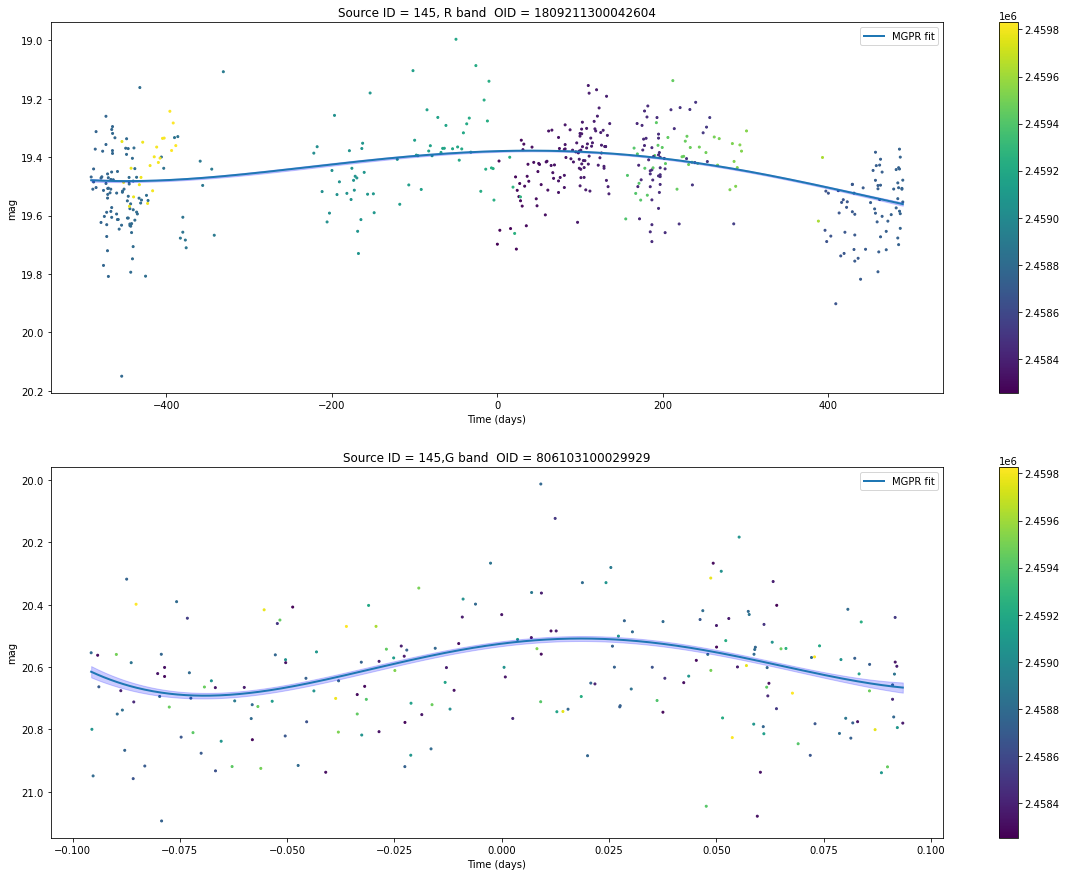

In [65]:
functions.MGPRfit(145,errscale=0.5)

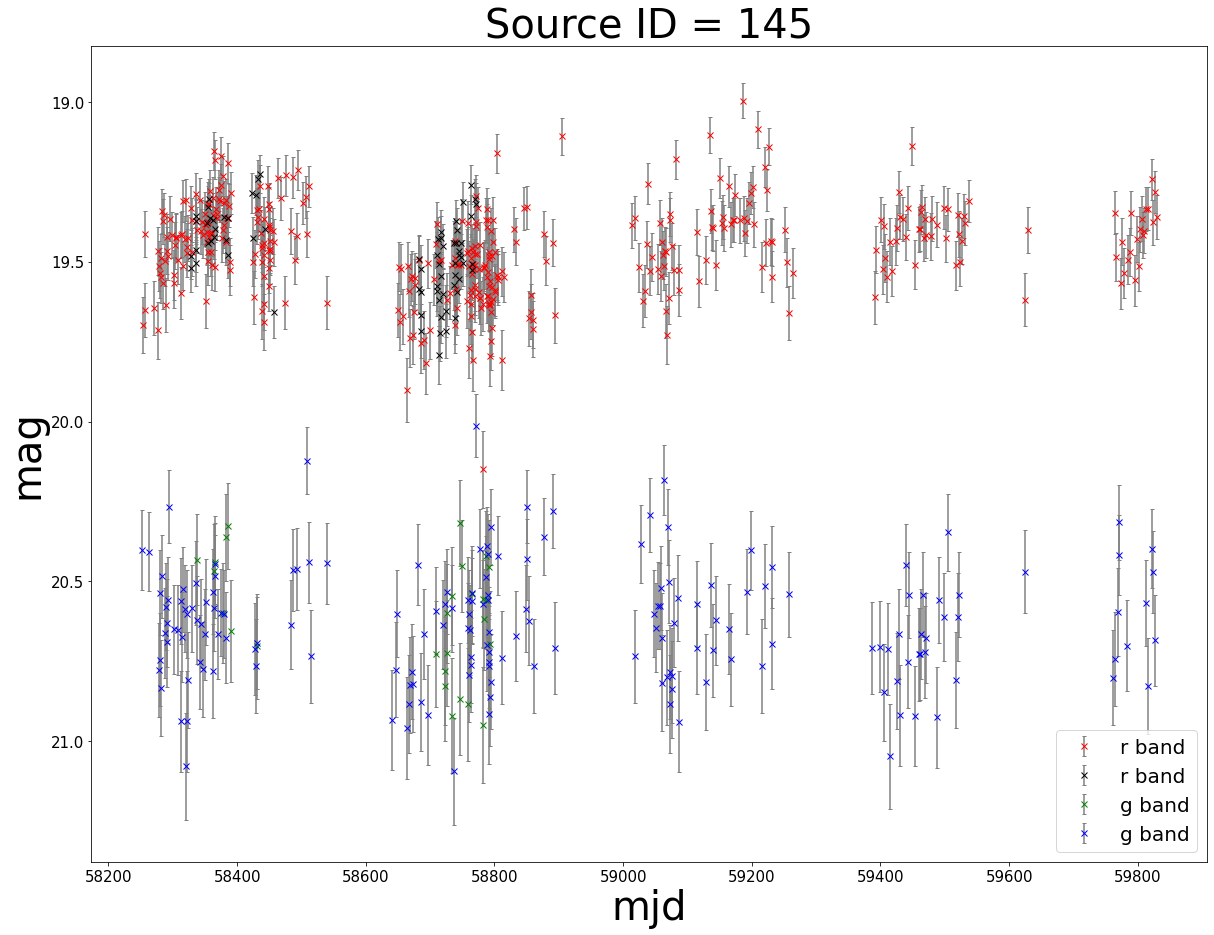

In [66]:
functions.draw_lightcurve(145)

In [67]:
functions.query(439)

SourceID,filter,OID,RA,DEC,numobs,DELTA_SIG_MAG,CONST_CHI2,sf,rmse,LNP_SIG,period,period_c,power,power_c,mean,std,min,max,sigma_mean,sigma_std,gaussian1_err,gaussian2_err,gumbel_err,g2_flag,Pg1g2,Pgug2,Pg1gu,shape,upsilon_class,upsilon_prob,upsilon_flag,upsilon_period
int32,str2,str16,float64,float64,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str2,str14,float64,float64,float64
439,zr,1809211300042148,5.0742247,59.3260104,68,24.0855770111084,1.4642729439121258,0.9511868759873303,0.11887487769126892,0.0004600938675696531,1.3914628119637142,2800.0,0.3612868249358036,0.011717249119181596,19.920970916748047,0.11887487769126892,19.683393478393555,20.19719696044922,-0.10407295823097229,1.2145365476608276,0.3015237875436522,0.2939809865129014,0.44909048586525974,0.0,0.45898348422516155,0.22692124166173633,0.6939116401576699,g1,CEPH_F,0.31,1.0,1.3909859943336642
439,zr,806203100043284,5.0741825,59.3260349,662,42.31599426269531,3.4373748469641683,8.763464508600559e-17,0.2168726772069931,6.84641750548418e-23,238.04133729120863,0.997343815080248,0.270724498758034,0.0669710949966615,20.104284286499023,0.2168726772069931,19.3428955078125,20.985332489013672,-0.26043152809143066,1.9058979749679565,0.008169558383902745,0.0012830310537330653,0.009699418886023034,0.0,0.014641262838516855,0.010439056165814531,0.5866762443357652,g2,EB_ED,0.62,1.0,1.0006102484084891


SourceID,filter,OID,RA,DEC,numobs,DELTA_SIG_MAG,CONST_CHI2,sf,rmse,LNP_SIG,period,period_c,power,power_c,mean,std,min,max,sigma_mean,sigma_std,gaussian1_err,gaussian2_err,gumbel_err,g2_flag,Pg1g2,Pgug2,Pg1gu,shape,upsilon_class,upsilon_prob,upsilon_flag,upsilon_period
int32,str2,str16,float64,float64,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str2,str14,float64,float64,float64


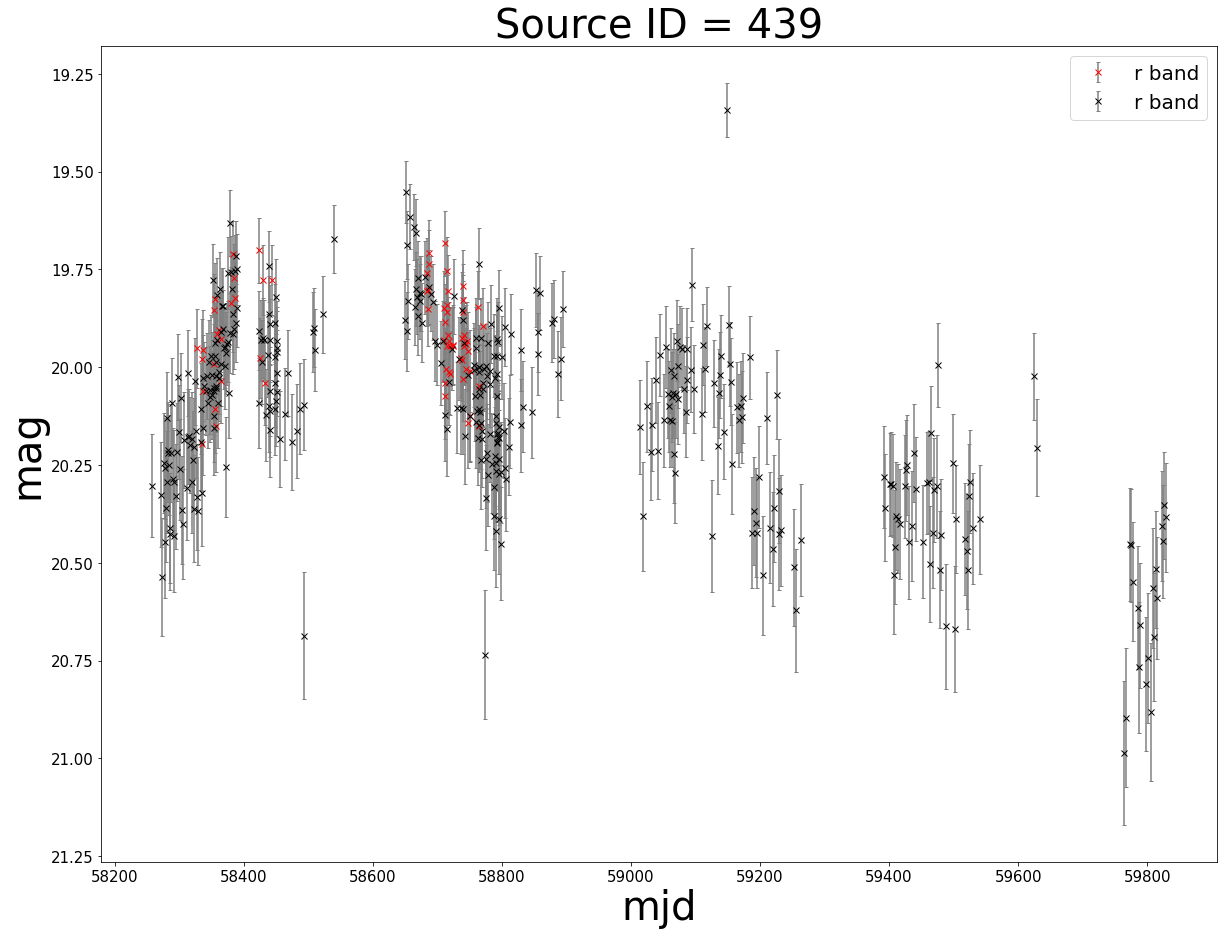

In [68]:
functions.draw_lightcurve(439)

L-S_period: 1.3914628119637142
fit_period: 1.6142932903737164
sin_chi2: 0.94306227
L-S_period: 238.04133729120863
fit_period: 243.94196123474327
sin_chi2: 3.36083225


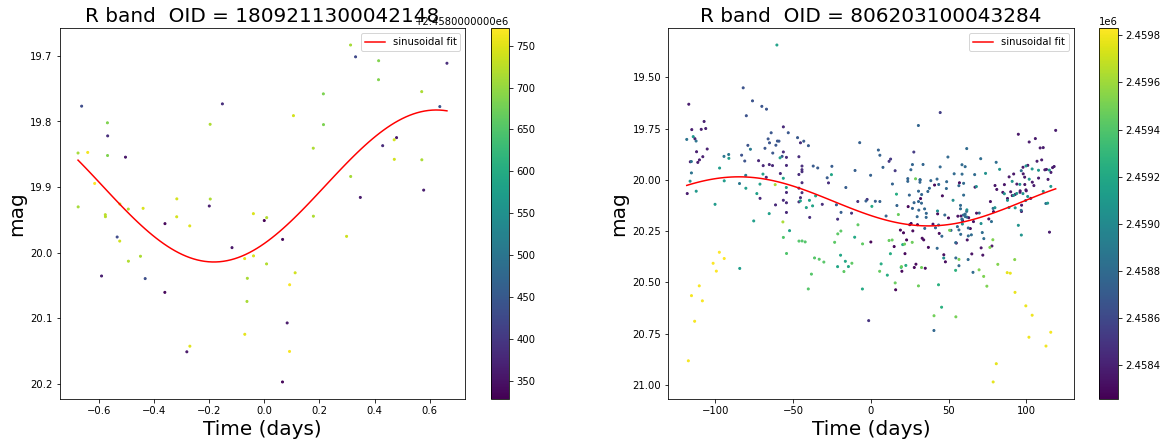

In [69]:
functions.sinfit(439)

In [70]:
functions.query(2813)

SourceID,filter,OID,RA,DEC,numobs,DELTA_SIG_MAG,CONST_CHI2,sf,rmse,LNP_SIG,period,period_c,power,power_c,mean,std,min,max,sigma_mean,sigma_std,gaussian1_err,gaussian2_err,gumbel_err,g2_flag,Pg1g2,Pgug2,Pg1gu,shape,upsilon_class,upsilon_prob,upsilon_flag,upsilon_period
int32,str2,str16,float64,float64,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str2,str14,float64,float64,float64
2813,zr,806203400051460,5.1056321,59.2459608,214,305.3210144042969,390.70754678491767,0.0,0.565703272819519,9.130724410339825e-12,368.4535100727675,1.0000014120485934,0.5216930985418803,0.4869248467327726,19.309696197509766,0.565703272819519,16.342483520507812,20.012256622314453,-4.518640041351318,23.71954917907715,0.018434855263553113,0.032260996341697934,0.019288172808330752,0.0,0.9999999999969353,0.9773542999047296,0.523031331679768,g1,NonVar,0.38,1.0,1909.2845833499996


SourceID,filter,OID,RA,DEC,numobs,DELTA_SIG_MAG,CONST_CHI2,sf,rmse,LNP_SIG,period,period_c,power,power_c,mean,std,min,max,sigma_mean,sigma_std,gaussian1_err,gaussian2_err,gumbel_err,g2_flag,Pg1g2,Pgug2,Pg1gu,shape,upsilon_class,upsilon_prob,upsilon_flag,upsilon_period
int32,str2,str16,float64,float64,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str2,str14,float64,float64,float64


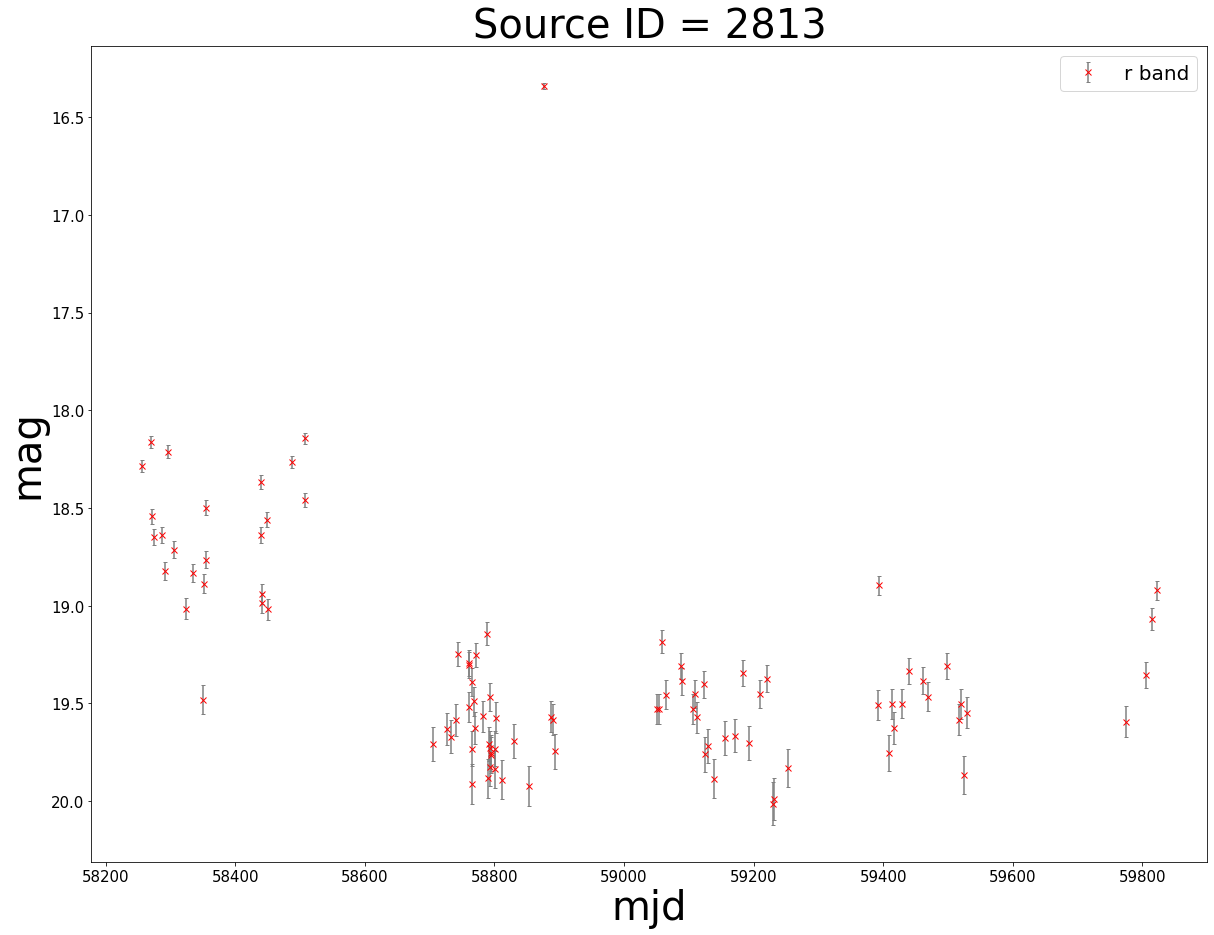

In [71]:
functions.draw_lightcurve(2813)

L-S_period: 368.4535100727675
fit_period: 371.32959488030764
sin_chi2: 439.89170967


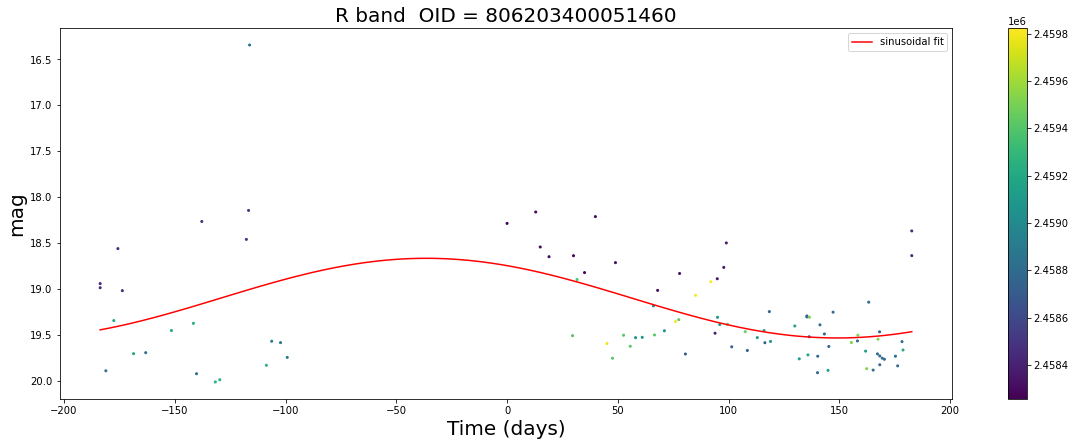

In [72]:
functions.sinfit(2813)

In [73]:
functions.query(50)

SourceID,filter,OID,RA,DEC,numobs,DELTA_SIG_MAG,CONST_CHI2,sf,rmse,LNP_SIG,period,period_c,power,power_c,mean,std,min,max,sigma_mean,sigma_std,gaussian1_err,gaussian2_err,gumbel_err,g2_flag,Pg1g2,Pgug2,Pg1gu,shape,upsilon_class,upsilon_prob,upsilon_flag,upsilon_period
int32,str2,str16,float64,float64,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str2,str14,float64,float64,float64
50,zr,806203100056992,5.0847793,59.305823,438,26.07579231262207,2.6107927423368156,0.000806971208849762,0.23083563148975372,3.463105648531134e-12,223.91194916677907,0.997343815080248,0.24246865168903964,0.06281874602726414,20.486726760864258,0.23083563148975372,19.869138717651367,21.093555450439453,-0.20032791793346405,1.6513630151748657,0.020899946420963187,0.010016017577819572,0.02540505403358542,0.0,0.12703363363379405,0.08768528986628421,0.5983224576127097,g1,LPV_SRV_AGB_O,0.86,0.0,226.33803819000025
50,zr,1809211300070206,5.0848415,59.3057772,46,22.17166519165039,2.217825294097687,0.2847788502030217,0.21391645073890686,6.0221749546566455e-05,0.5083811140507174,2800.0,0.5296320007600701,0.15438356554563615,20.468717575073242,0.21391645073890686,20.032848358154297,21.13528823852539,-0.18498404324054718,1.5076112747192383,0.17223729353562936,0.12687535031422165,0.24294313257932024,0.0,0.2811236022375865,0.1493102749960884,0.669329676063277,g1,LPV_Mira_AGB_C,0.38,1.0,652.2697222499955


SourceID,filter,OID,RA,DEC,numobs,DELTA_SIG_MAG,CONST_CHI2,sf,rmse,LNP_SIG,period,period_c,power,power_c,mean,std,min,max,sigma_mean,sigma_std,gaussian1_err,gaussian2_err,gumbel_err,g2_flag,Pg1g2,Pgug2,Pg1gu,shape,upsilon_class,upsilon_prob,upsilon_flag,upsilon_period
int32,str2,str16,float64,float64,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str2,str14,float64,float64,float64


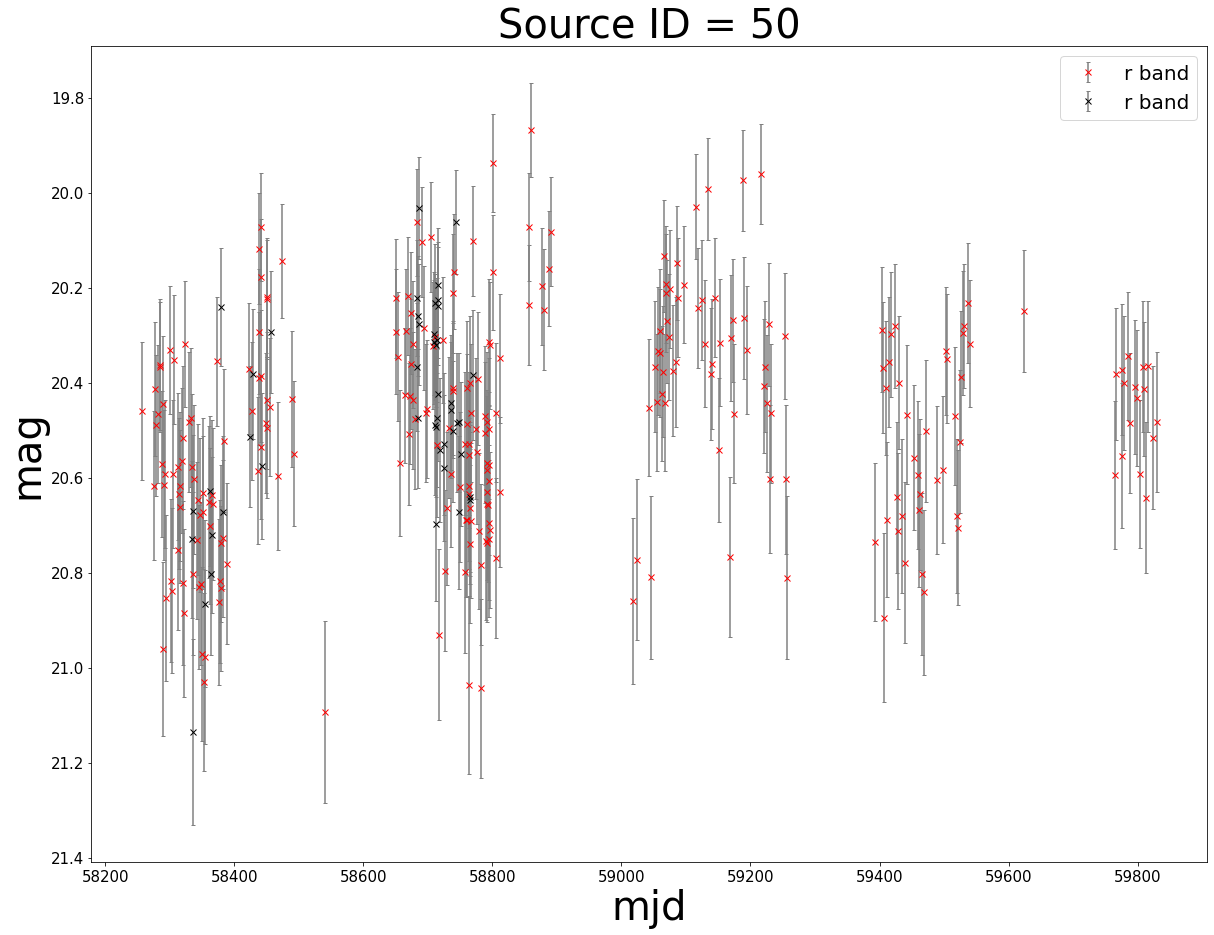

In [74]:
functions.draw_lightcurve(50)

No data found in G band


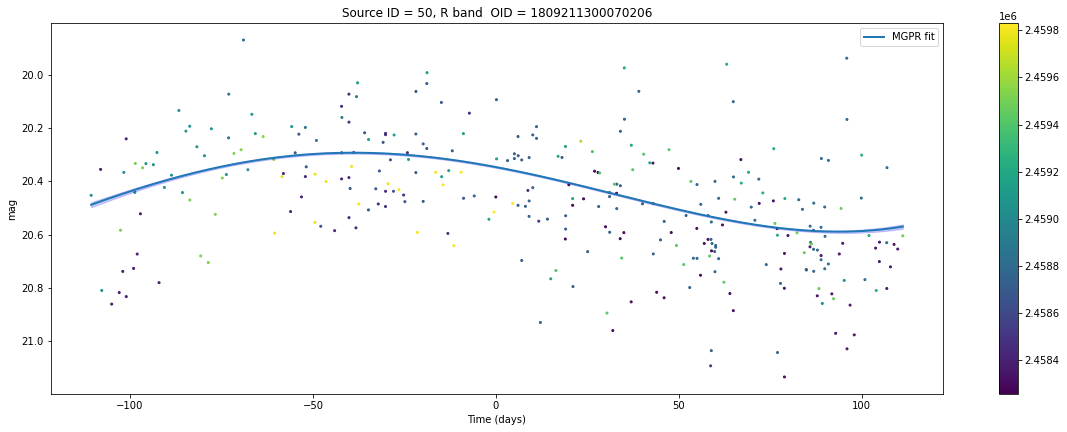

In [75]:
functions.MGPRfit(50,errscale=0.25)

L-S_period: 223.91194916677907
fit_period: 248.1809944508579
sin_chi2: 2.04205657
L-S_period: 0.5083811140507174
fit_period: 0.4637608499208568
sin_chi2: 1.07210292


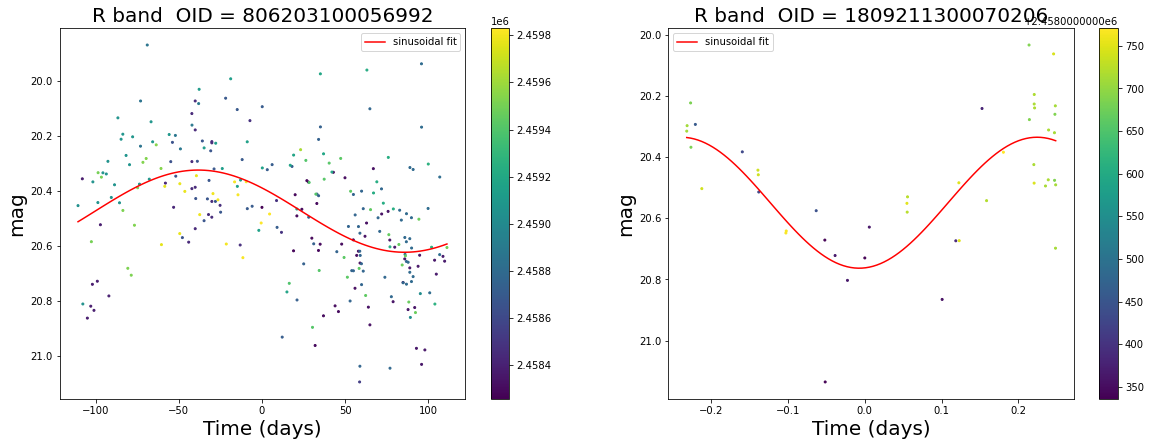

In [76]:
functions.sinfit(50)

In [96]:
t=obj_zr
simbad=np.zeros((len(t),2))
for i,row in enumerate(t):
    simbad[i,0]=row['RA']
    simbad[i,1]=row['DEC']
np.savetxt('simbad_periodic_zr.txt',simbad,fmt='%.18f')

In [97]:
t=obj_zg
simbad=np.zeros((len(t),2))
for i,row in enumerate(t):
    simbad[i,0]=row['RA']
    simbad[i,1]=row['DEC']
np.savetxt('simbad_periodic_zg.txt',simbad,fmt='%.18f')

In [116]:
t=np.unique(unobj_zr['SourceID'])
simbad=np.zeros((len(t),2))
for i,row in enumerate(t):
    simbad[i,0]=np.mean(unobj_zr[unobj_zr['SourceID']==row]['RA'])
    simbad[i,1]=np.mean(unobj_zr[unobj_zr['SourceID']==row]['DEC'])
np.savetxt('simbad_nonperiodic_zr.txt',simbad,fmt='%.18f')

In [117]:
t=np.unique(unobj_zg['SourceID'])
simbad=np.zeros((len(t),2))
for i,row in enumerate(t):
    simbad[i,0]=np.mean(unobj_zg[unobj_zg['SourceID']==row]['RA'])
    simbad[i,1]=np.mean(unobj_zg[unobj_zg['SourceID']==row]['DEC'])
np.savetxt('simbad_nonperiodic_zg.txt',simbad,fmt='%.18f')

In [2]:
functions.query(1299)

SourceID,filter,OID,RA,DEC,numobs,DELTA_SIG_MAG,CONST_CHI2,sf,rmse,LNP_SIG,period,period_c,power,power_c,mean,std,min,max,sigma_mean,sigma_std,gaussian1_err,gaussian2_err,gumbel_err,g2_flag,Pg1g2,Pgug2,Pg1gu,shape,upsilon_class,upsilon_prob,upsilon_flag,upsilon_period
int32,str2,str16,float64,float64,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str2,str14,float64,float64,float64
1299,zr,806203100023129,5.1539289,59.3135314,854,197.82797241210938,2.7845959916233016,8.530009142395865e-08,0.05892377719283104,2.8366516059465913e-31,3.4010475333652077,0.997336033066433,0.3032918259204402,0.01030609793810549,18.332311630249023,0.05892377719283104,18.088233947753906,18.604610443115234,-0.06086678430438042,1.6700814962387085,0.21225719823248787,0.011460107658360516,0.4472967585450967,0.0,0.001766289233870677,0.0003999268603702699,0.8267342562578373,g2,EB_ESD,0.68,0.0,3.4026291468117074
1299,zr,1809211300007283,5.1539485,59.3135173,77,140.62802124023438,3.841370007592759,2.510158888045934e-06,0.06144300103187561,1.1884953264989655e-11,3.4027659269629043,2800.0,0.5868525678804262,0.014952468343091855,18.3205623626709,0.06144300103187561,18.164974212646484,18.451139450073242,-0.07494369149208069,1.95154869556427,0.6638399794514294,0.8100882631890592,1.2727447216483052,1.0,0.6592933533588327,0.21553953910323265,0.7950424032726369,g1,CEPH_1O,0.46,1.0,3.4069062499999956


SourceID,filter,OID,RA,DEC,numobs,DELTA_SIG_MAG,CONST_CHI2,sf,rmse,LNP_SIG,period,period_c,power,power_c,mean,std,min,max,sigma_mean,sigma_std,gaussian1_err,gaussian2_err,gumbel_err,g2_flag,Pg1g2,Pgug2,Pg1gu,shape,upsilon_class,upsilon_prob,upsilon_flag,upsilon_period
int32,str2,str16,float64,float64,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str2,str14,float64,float64,float64
1299,zg,806103100019786,5.1539114,59.3135274,324,53.868614196777344,1.8394977186270967,0.848191583688778,0.09805630892515182,1.6596364604563349e-09,3.4011826003596766,1.0000143393856216,0.1611956743979476,0.01409755046782724,19.541732788085938,0.09805630892515182,19.238975524902344,19.853981018066406,-0.08506390452384949,1.3622061014175415,0.1311333635141622,0.0479548350857191,0.17169875157514314,0.0,0.07592957735864703,0.045136972916553275,0.6344200062484924,g2,EB_ESD,0.39,0.0,3.40276444096024
1299,zg,1809111300037238,5.1539493,59.3135091,62,41.663726806640625,1.5354402319381353,0.9093189449280512,0.09419509768486023,0.004309321596730584,3.4328141039860687,2800.0,0.3364783323053183,0.050906851019238746,19.51762580871582,0.09419509768486023,19.218833923339844,19.73865509033203,-0.07683558017015457,1.2365236282348633,0.1696208173624249,0.0687546168006633,0.4345514778805323,1.0,0.09245406044102589,0.014856594651591726,0.8811322337792876,g1,DSCT,0.56,1.0,0.03187954314595965


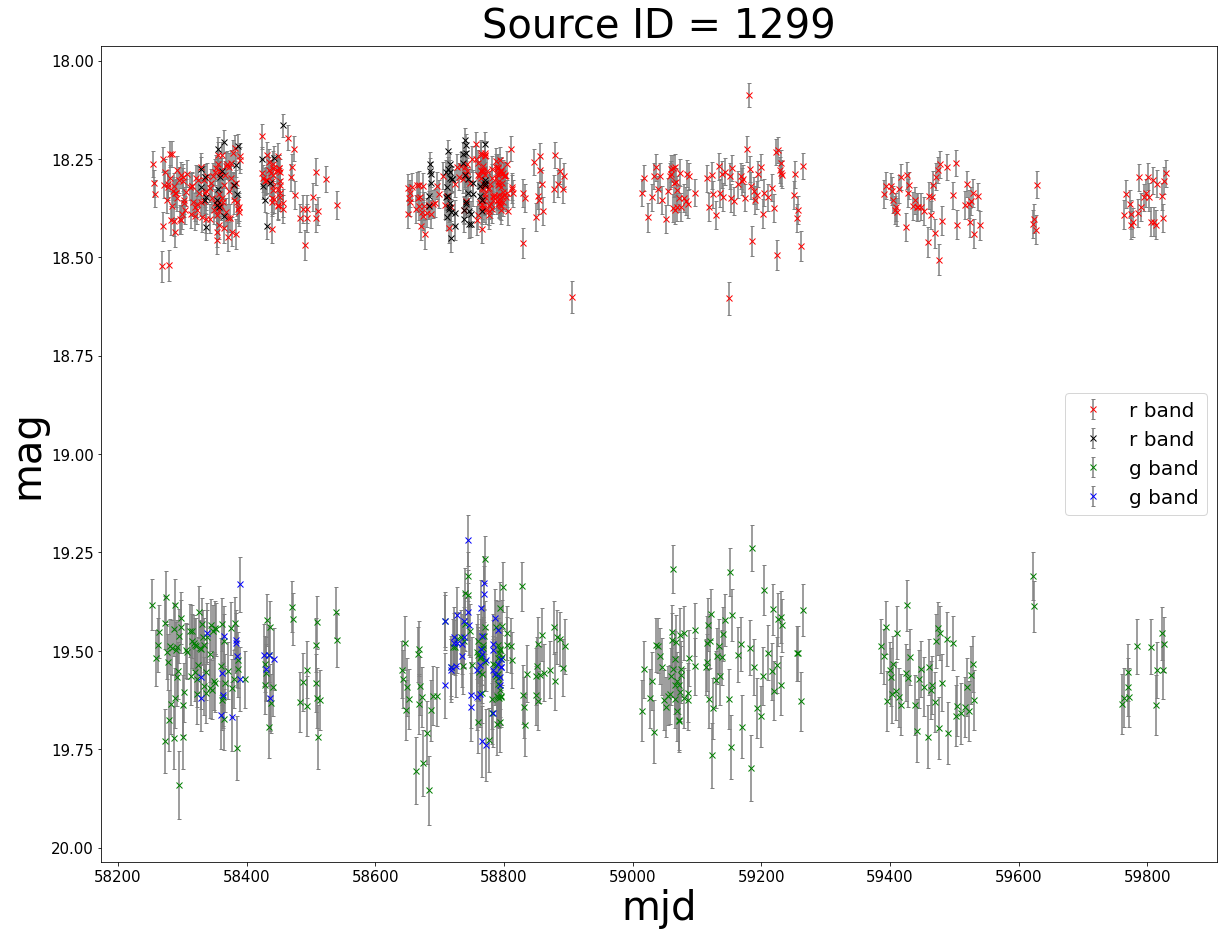

In [4]:
functions.draw_lightcurve(1299)

L-S_period: 3.4010475333652077
fit_period: 3.6399105150623
sin_chi2: 1.92680736
L-S_period: 3.4027659269629043
fit_period: 3.6923396490829967
sin_chi2: 1.58207348
L-S_period: 3.4011826003596766
fit_period: 3.150622478749635
sin_chi2: 1.56260055
L-S_period: 3.4328141039860687
fit_period: 3.5395421307623556
sin_chi2: 1.02911794


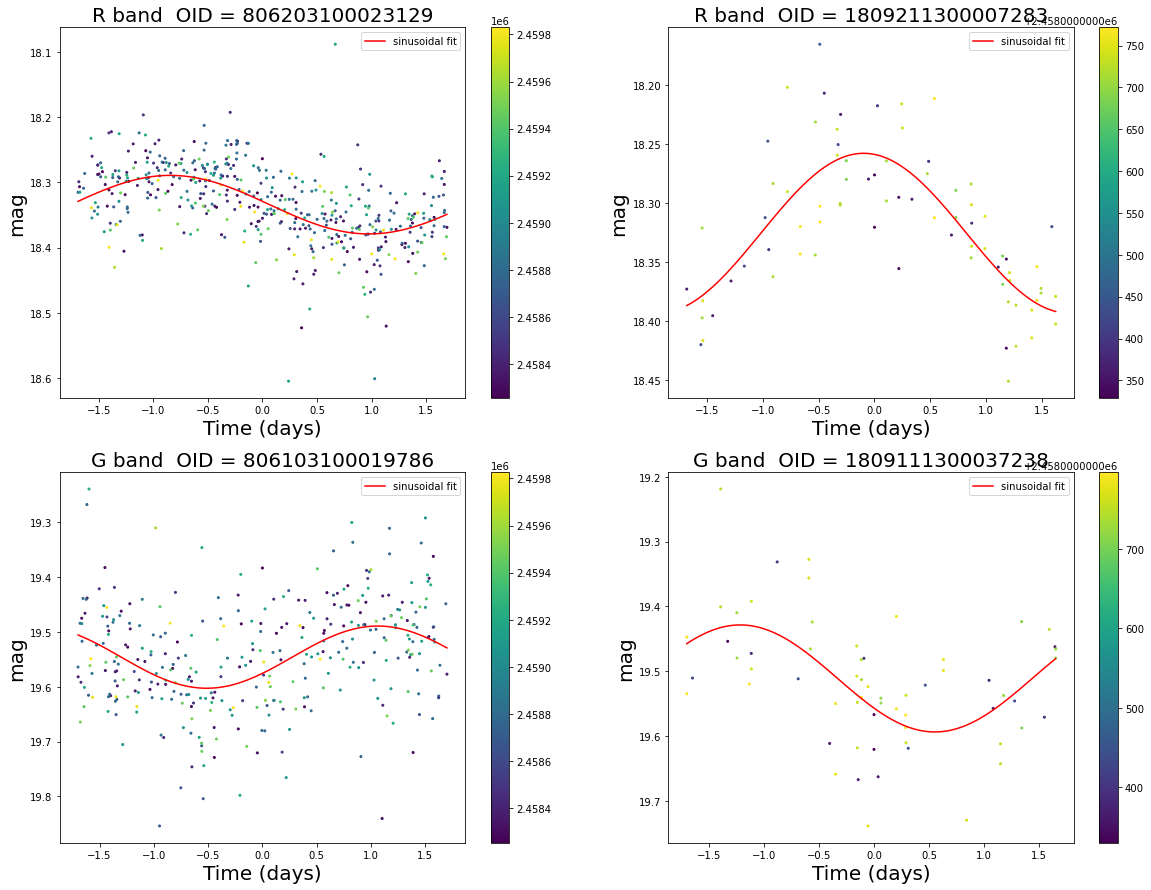

In [5]:
functions.sinfit(1299)